# Post-Hoc Multivariate Decomposition of Change Points in PHQ-9 Longitudinal Data

**Author**: Satyaki Mitra  
**Date**: February 2026  
**Purpose**: Rigorous statistical decomposition of univariate change points to assess multivariate signal contribution

---

## Executive Summary

This notebook performs a **post-hoc multivariate decomposition** of the three change points detected via univariate PELT on the Coefficient of Variation (CV) signal:

- **Day 24** (Week 3.5): Early response phase
- **Day 57** (Week 8.0): Peak divergence phase  
- **Day 133** (Week 19.0): Maintenance consolidation

### Research Question

> **Do different distributional moments (Mean, CV, Skewness, %Severe) exhibit distinct shift patterns at each change point, providing evidence that multivariate signals contain unique clinical information beyond univariate CV detection?**

### Hypotheses

**H1**: Day 24 is primarily driven by **Mean decrease** (early responders improving, reducing overall severity)  
**H2**: Day 57 is primarily driven by **CV increase** (polarization between responders/non-responders)  
**H3**: Day 133 is primarily driven by **Skewness increase** (emergence of non-responder tail in maintenance phase)

### Analytical Approach

1. **Feature Engineering**: Construct 4D daily state vector [Mean, CV, Skewness, %Severe]  
2. **Robust Variants**: Compute robust equivalents [Median, Quartile-CV, Bowley Skewness, %Severe]  
3. **Segment Analysis**: Compare pre/post distributions at each CP using effect sizes  
4. **Attribution**: Decompose total Mahalanobis distance into per-dimension contributions  
5. **Validation**: Statistical testing with Bonferroni correction for multiple comparisons

---

## Dependencies

In [2]:
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu 
from scipy.spatial.distance import mahalanobis

warnings.filterwarnings('ignore')


## Setup

In [3]:
# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

plt.rcParams['figure.figsize']  = (14, 8)
plt.rcParams['font.size']       = 11
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 10

# Set random seed for reproducibility
np.random.seed(2023)


## Data Loading and Preprocessing

In [4]:
# Load the Gamma dataset (winner from distribution comparison)
DATA_PATH                         = Path('../data/raw/synthetic_phq9_data_gamma.csv')
RESULTS_PATH                      = Path('../results/detection/gamma')

# Load raw PHQ-9 data (Days as rows, Patients as columns)
dataframe                         = pd.read_csv(filepath_or_buffer = DATA_PATH,
                                                index_col          = 0,
                                               )



# Convert from wide to long format
dataframe_converted               = dataframe.reset_index().melt(id_vars    = 'Day',
                                                                 var_name   = 'patient_id', 
                                                                 value_name = 'phq9_score',
                                                                )

# Clean up
dataframe_converted['day']        = dataframe_converted['Day'].str.replace('Day_', '').astype(int) - 1        # 0-indexed days
dataframe_converted['patient_id'] = dataframe_converted['patient_id'].str.replace('Patient_', '').astype(int)
dataframe_converted               = dataframe_converted[['patient_id', 'day', 'phq9_score']].dropna()         # Remove missing values

final_dataframe                   = dataframe_converted.copy()


print(f"Dataset loaded: {final_dataframe.shape[0]:,} observations across {final_dataframe['patient_id'].nunique():,} patients")
print(f"Study duration: {final_dataframe['day'].max()} days")
print(f"Missingness: {(1 - len(final_dataframe) / (final_dataframe['patient_id'].nunique() * (final_dataframe['day'].max() + 1))) * 100:.2f}%")



# Load detected change points from PELT-L1 (best model)
with open(RESULTS_PATH / 'per_model/pelt_l1.json', 'r') as f:
    pelt_results = json.load(f)

CHANGEPOINTS = pelt_results['change_points']

print(f"\nDetected change points (PELT-L1): {CHANGEPOINTS}")
print(f"Phases: [0-{CHANGEPOINTS[0]}], [{CHANGEPOINTS[0]}-{CHANGEPOINTS[1]}], [{CHANGEPOINTS[1]}-{CHANGEPOINTS[2]}], [{CHANGEPOINTS[2]}-365]")


final_dataframe.head()


Dataset loaded: 13,680 observations across 1,000 patients
Study duration: 364 days
Missingness: 96.25%

Detected change points (PELT-L1): [24, 57, 133]
Phases: [0-24], [24-57], [57-133], [133-365]


,patient_id,day,phq9_score
8,1,8,17.670854
41,1,41,19.046299
47,1,47,15.046035
58,1,58,25.494282
64,1,64,23.093995


## Feature Engineering: Daily Distributional Moments

We construct two sets of features:

### Standard Moments
- **Mean**: $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$
- **CV**: $\text{CV} = \frac{\sigma}{\mu}$ where $\sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \mu)^2}$
- **Skewness**: $\gamma = \frac{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^3}{\sigma^3}$
- **% Severe**: Proportion of scores ≥ 20 (severe depression threshold)

### Robust Equivalents
- **Median**: $Q_2$ (50th percentile)
- **Quartile CV**: $\text{QCV} = \frac{Q_3 - Q_1}{Q_2}$ (IQR normalized by median)
- **Bowley Skewness**: $\gamma_B = \frac{(Q_3 - Q_2) - (Q_2 - Q_1)}{Q_3 - Q_1}$
- **% Severe**: Same as above (count-based, already robust)

In [5]:
def compute_daily_features(df, severe_threshold=20):
    """
    Compute both standard and robust distributional features for each day
    
    Arguments:
    ----------
        df          { pd.DataFrame } : Raw PHQ-9 data with columns ['patient_id', 'day', 'phq9_score']
        
        severe_threshold { int }     : PHQ-9 score threshold for severe depression (default: 20)

    Returns:
    --------
           { pd.DataFrame }.         : Daily features with columns for both standard and robust metrics
    """
    features = list()
    
    for day in range(df['day'].max() + 1):
        day_data = df[df['day'] == day]['phq9_score'].values
        
        # Need at least 2 observations
        if (len(day_data) < 2):  
            continue
        
        # Standard moments
        mean           = np.mean(day_data)
        std            = np.std(day_data, ddof=1)
        cv             = std / mean if (mean > 0) else 0
        skewness       = stats.skew(day_data, bias = False) if (len(day_data) >= 3) else 0
        pct_severe     = (day_data >= severe_threshold).mean() * 100
        
        # Robust equivalents
        q1, median, q3 = np.percentile(day_data, [25, 50, 75])
        iqr            = q3 - q1
        quartile_cv    = iqr / median if median > 0 else 0
        
        # Bowley skewness (quartile-based)
        if (q3 - q1 > 0):
            bowley_skew = ((q3 - median) - (median - q1)) / (q3 - q1)
            
        else:
            bowley_skew = 0
        
        features.append({'day'            : day,
                         'n_observations' : len(day_data),
                         'mean'           : mean,
                         'std'            : std,
                         'cv'             : cv,
                         'skewness'       : skewness,
                         'pct_severe'     : pct_severe,
                         'median'         : median,
                         'q1'             : q1,
                         'q3'             : q3,
                         'iqr'            : iqr,
                         'quartile_cv'    : quartile_cv,
                         'bowley_skew'    : bowley_skew,
                       })
    
    return pd.DataFrame(features)


# Compute features
daily_features = compute_daily_features(df = final_dataframe)

print(f"Daily features computed for {len(daily_features)} days")
print(f"\nFeature summary:")
print(daily_features[['mean', 'cv', 'skewness', 'pct_severe']].describe())

daily_features.head(10)


Daily features computed for 365 days

Feature summary:
             mean          cv    skewness  pct_severe
count  365.000000  365.000000  365.000000  365.000000
mean    10.845189    0.406311   -0.094097    2.358845
std      1.854624    0.080518    0.352342    3.763664
min      7.562750    0.222185   -0.985492    0.000000
25%      9.644498    0.350541   -0.345302    0.000000
50%     10.335677    0.411718   -0.088727    0.000000
75%     11.474939    0.457031    0.117443    3.571429
max     16.766617    0.672483    1.206839   19.607843


,day,n_observations,mean,std,cv,skewness,pct_severe,median,q1,q3,iqr,quartile_cv,bowley_skew
0,0,53,16.766617,3.973505,0.236989,-0.067190,15.094340,17.010574,14.151137,19.230429,5.079292,0.298596,-0.125920
1,1,61,15.962573,3.918884,0.245505,0.414111,14.754098,15.706900,13.160578,18.042213,4.881635,0.310796,-0.043225
2,2,60,16.105675,4.176626,0.259326,-0.020035,18.333333,16.659190,13.042192,19.204898,6.162706,0.369928,-0.173834
3,3,56,15.767291,4.416561,0.280109,-0.051384,16.071429,15.980006,13.103968,18.586774,5.482806,0.343104,-0.049112
4,4,54,15.164034,4.297926,0.283429,-0.151309,16.666667,15.126748,12.044418,18.390637,6.346219,0.419536,0.028609
5,5,50,16.430227,4.051870,0.246611,0.015292,12.000000,16.970298,14.110414,18.808084,4.697671,0.276817,-0.217576
6,6,58,16.206486,3.983484,0.245796,0.044820,15.517241,16.267162,12.620101,19.128650,6.508549,0.400104,-0.120699
7,7,58,16.080755,4.030122,0.250618,-0.056072,17.241379,16.301628,13.451534,18.918522,5.466988,0.335365,-0.042656
8,8,55,14.770753,3.672199,0.248613,-0.421869,5.454545,14.973961,12.521555,17.070343,4.548788,0.303780,-0.078268
9,9,62,15.805837,4.312424,0.272837,-0.350786,16.129032,16.433686,13.048679,18.853147,5.804467,0.353205,-0.166345


## Plot Coefficient of Variation Timeseries 

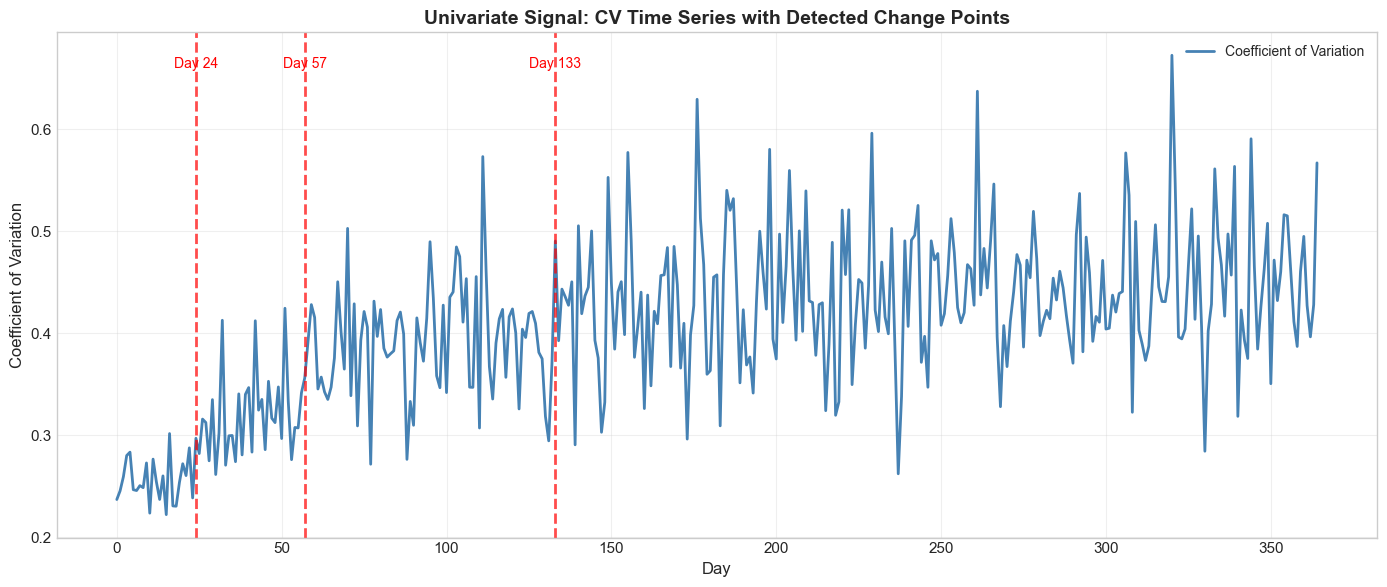

In [6]:
fig, ax = plt.subplots(figsize = (14, 6))

# Plot CV time series
ax.plot(daily_features['day'], daily_features['cv'], 
        linewidth=2, color='steelblue', label='Coefficient of Variation')

# Mark change points
for cp in CHANGEPOINTS:
    ax.axvline(cp, 
               color     = 'red',
               linestyle = '--', 
               linewidth = 2, 
               alpha     = 0.7,
              )
    
    ax.text(x        = cp, 
            y        = ax.get_ylim()[1]*0.95, 
            s        = f'Day {cp}', 
            ha       = 'center', 
            fontsize = 10, 
            color    = 'red')

ax.set_xlabel('Day', fontsize = 12)
ax.set_ylabel('Coefficient of Variation', fontsize = 12)

ax.set_title(label      = 'Univariate Signal: CV Time Series with Detected Change Points', 
             fontsize   = 14, 
             fontweight = 'bold',
            )

ax.legend()
ax.grid(True, alpha = 0.3)

plt.tight_layout()

plt.savefig(fname       = '../results/post_hoc_analysis/cv_timeseries.png', 
            dpi         = 300, 
            bbox_inches = 'tight',
           )

plt.show()


## Visual Inspection: Time Series of All Features

#### Before formal analysis, visualize how each feature evolves over time with change points marked

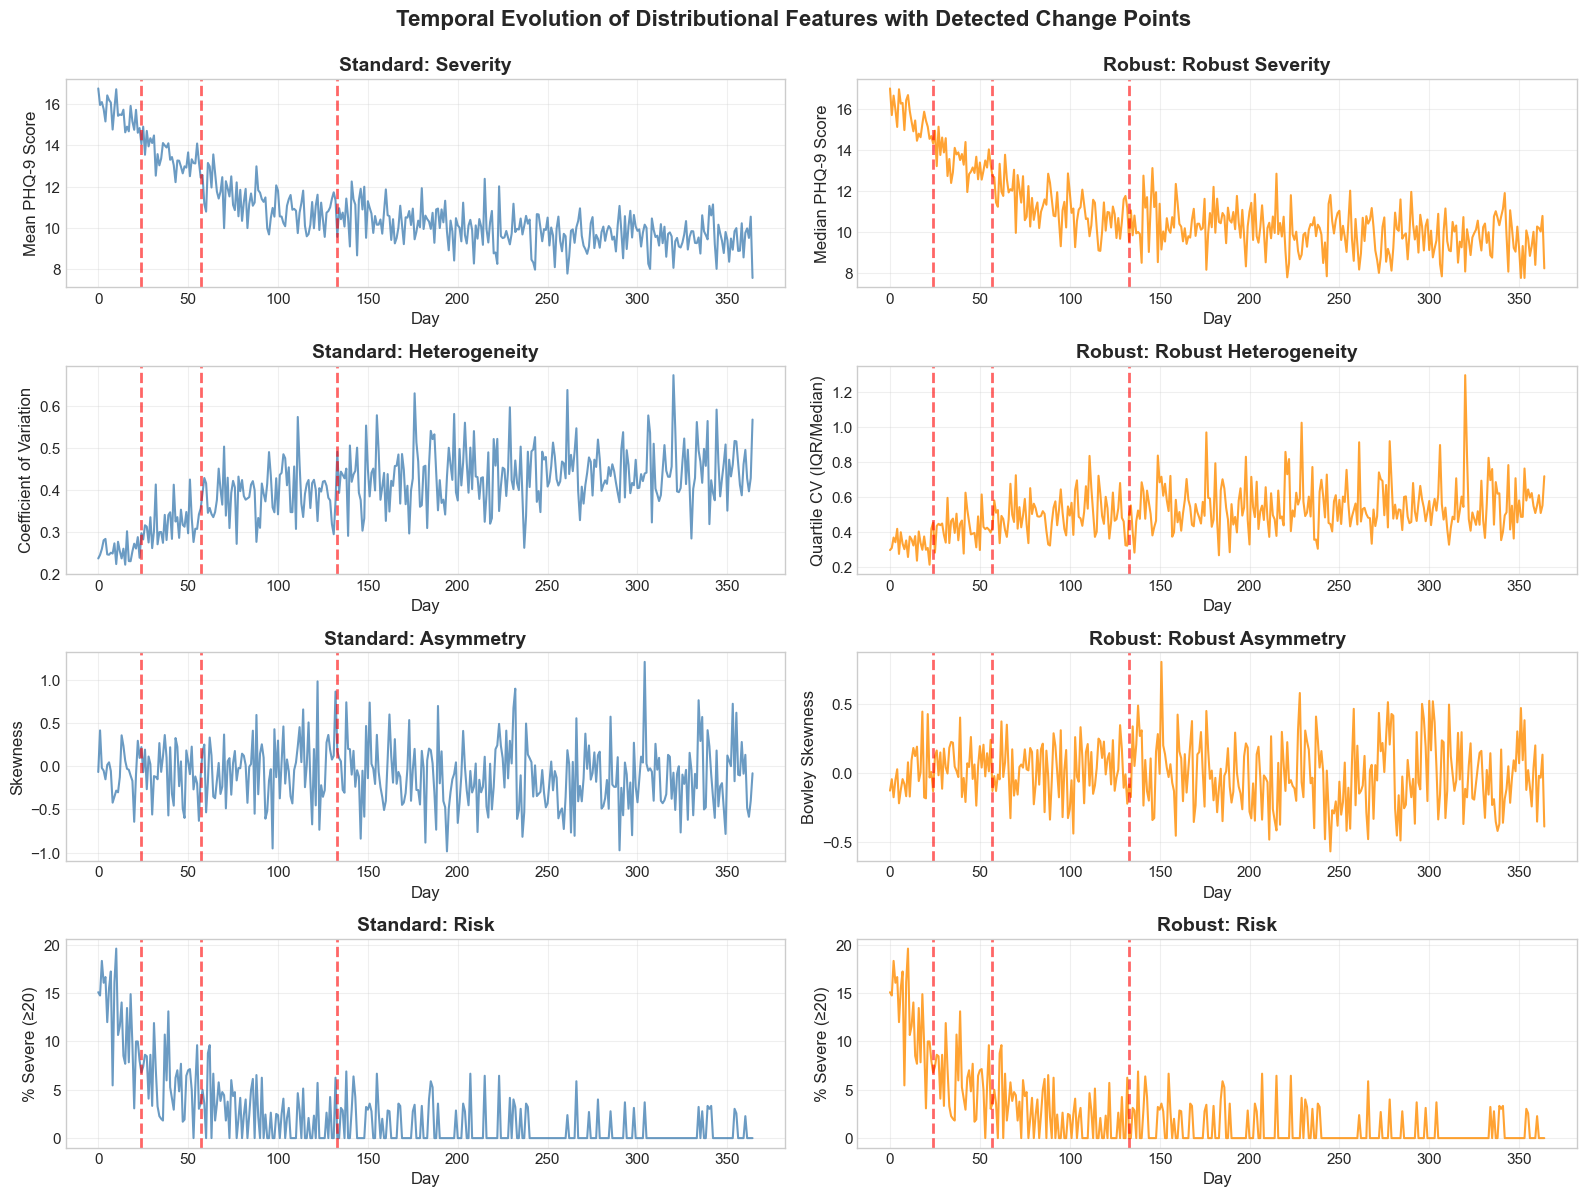


🔍 Visual Inspection Notes:
- Red dashed lines mark detected change points (Days 24, 57, 133)
- Left column: Standard moments (sensitive to outliers)
- Right column: Robust equivalents (quartile-based)
- Look for visual 'jumps' or trend changes at CPs


In [7]:
def plot_feature_time_series(features_df, changepoints, figsize = (16, 12)):
    """
    Plot time series for all features with change points marked
    """
    fig, axes = plt.subplots(nrows   = 4, 
                             ncols   = 2, 
                             figsize = figsize,
                            )
    
    fig.suptitle(t          = 'Temporal Evolution of Distributional Features with Detected Change Points', 
                 fontsize   = 16, 
                 fontweight = 'bold', 
                 y          = 0.995,
                )
    
    # Standard features (left column)
    standard_features = [('mean', 'Mean PHQ-9 Score', 'Severity'),
                         ('cv', 'Coefficient of Variation', 'Heterogeneity'),
                         ('skewness', 'Skewness', 'Asymmetry'),
                         ('pct_severe', '% Severe (≥20)', 'Risk'),
                        ]
    
    # Robust features (right column)
    robust_features   = [('median', 'Median PHQ-9 Score', 'Robust Severity'),
                         ('quartile_cv', 'Quartile CV (IQR/Median)', 'Robust Heterogeneity'),
                         ('bowley_skew', 'Bowley Skewness', 'Robust Asymmetry'),
                         ('pct_severe', '% Severe (≥20)', 'Risk'),
                        ]
    
    for i, (std_feat, robust_feat) in enumerate(zip(standard_features, robust_features)):
        # Standard feature (left)
        ax_std = axes[i, 0]
        
        ax_std.plot(features_df['day'], 
                    features_df[std_feat[0]], 
                    linewidth = 1.5, 
                    alpha     = 0.8, 
                    color     = 'steelblue',
                   )
        
        # Mark change points
        for cp in changepoints:
            ax_std.axvline(cp, 
                           color     = 'red',
                           linestyle = '--', 
                           alpha     = 0.6, 
                           linewidth = 2,
                          )
        
        ax_std.set_xlabel('Day')
        ax_std.set_ylabel(std_feat[1])
        
        ax_std.set_title(f'Standard: {std_feat[2]}', fontweight = 'bold')
        ax_std.grid(True, alpha = 0.3)
        
        # Robust feature (right)
        ax_robust = axes[i, 1]
        ax_robust.plot(features_df['day'], 
                       features_df[robust_feat[0]], 
                       linewidth = 1.5, 
                       alpha     = 0.8, 
                       color     = 'darkorange',
                      )
        
        # Mark change points
        for cp in changepoints:
            ax_robust.axvline(cp, 
                              color     = 'red', 
                              linestyle = '--', 
                              alpha     = 0.6, 
                              linewidth = 2,
                             )
        
        ax_robust.set_xlabel('Day')
        ax_robust.set_ylabel(robust_feat[1])
        ax_robust.set_title(f'Robust: {robust_feat[2]}', fontweight = 'bold')
        ax_robust.grid(True, alpha = 0.3)
    
    plt.tight_layout()
    
    plt.savefig(fname = '../results/post_hoc_analysis/all_features_time_series_plot.png')
    
    return fig


fig = plot_feature_time_series(daily_features, CHANGEPOINTS)

plt.show()

print("\n🔍 Visual Inspection Notes:")
print("- Red dashed lines mark detected change points (Days 24, 57, 133)")
print("- Left column: Standard moments (sensitive to outliers)")
print("- Right column: Robust equivalents (quartile-based)")
print("- Look for visual 'jumps' or trend changes at CPs")


## Segmentation: Pre/Post Change Point Analysis

For each change point, we define:
- **Pre-segment**: Window of days before the CP
- **Post-segment**: Window of days after the CP

We use a **symmetric window** of ±10 days around each CP to ensure balanced sample sizes.

In [8]:
def create_segments(features_df, changepoints, window = 10):
    """
    Create pre/post segments around each change point
    
    Arguments:
    ----------
        features_df { pd.DataFrame } : Daily features
    
        changepoints   { list }      : List of change point days
        
        window         { int }       : Number of days before/after CP to include in segments
    
    Returns:
    --------
                    { dict }         : Nested dict with structure: {cp: {'pre': DataFrame, 'post': DataFrame}}
    """
    segments = {}
    
    for cp in changepoints:
        # Define boundaries
        pre_start    = max(0, cp - window)
        pre_end      = cp
        post_start   = cp
        post_end     = min(features_df['day'].max(), cp + window)
        
        # Extract segments
        pre_segment  = features_df[(features_df['day'] >= pre_start) &  (features_df['day'] < pre_end)].copy()
        
        post_segment = features_df[(features_df['day'] >= post_start) & (features_df['day'] < post_end)].copy()
        
        segments[cp] = {'pre' : pre_segment,
                        'post'       : post_segment,
                        'pre_range'  : (pre_start, pre_end),
                        'post_range' : (post_start, post_end),
                       }
    
    return segments

# Create segments with ±10 day windows
segments = create_segments(features_df  = daily_features, 
                           changepoints = CHANGEPOINTS, 
                           window       = 10,
                          )


print("Segment Analysis:")
print("=" * 80)
for cp in CHANGEPOINTS:
    print(f"\nChange Point: Day {cp}")
    print(f"  Pre-segment:  Days {segments[cp]['pre_range'][0]:3d} - {segments[cp]['pre_range'][1]:3d} (n={len(segments[cp]['pre']):2d})")
    print(f"  Post-segment: Days {segments[cp]['post_range'][0]:3d} - {segments[cp]['post_range'][1]:3d} (n={len(segments[cp]['post']):2d})")
    


Segment Analysis:

Change Point: Day 24
  Pre-segment:  Days  14 -  24 (n=10)
  Post-segment: Days  24 -  34 (n=10)

Change Point: Day 57
  Pre-segment:  Days  47 -  57 (n=10)
  Post-segment: Days  57 -  67 (n=10)

Change Point: Day 133
  Pre-segment:  Days 123 - 133 (n=10)
  Post-segment: Days 133 - 143 (n=10)


## Effect Size Computation: Cohen's d

For each feature at each change point, we compute **Cohen's d** effect size:

$$d = \frac{\mu_{\text{post}} - \mu_{\text{pre}}}{s_{\text{pooled}}}$$

where the pooled standard deviation is:

$$s_{\text{pooled}} = \sqrt{\frac{(n_{\text{pre}} - 1)s_{\text{pre}}^2 + (n_{\text{post}} - 1)s_{\text{post}}^2}{n_{\text{pre}} + n_{\text{post}} - 2}}$$

### Interpretation Guidelines (Cohen, 1988)
- $|d| < 0.2$: Trivial
- $0.2 \leq |d| < 0.5$: Small
- $0.5 \leq |d| < 0.8$: Medium
- $|d| \geq 0.8$: Large

In [9]:
def cohens_d(x1, x2):
    """
    Compute Cohen's d effect size between two samples
    
    Argument:
    ---------
        x1 { array-like } : First sample to compare
        
        x2 { array-like } : Second sample to compare
    
    Returns:
    --------
            { float }     : Cohen's d effect size
    """
    n1         = len(x1)
    n2         = len(x2)
    var1       = np.var(x1, ddof = 1)
    var2       = np.var(x2, ddof = 1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Effect size
    d          = (np.mean(x2) - np.mean(x1)) / pooled_std if (pooled_std > 0) else 0
    
    return d


def effect_size_interpretation(d):
    """
    Interpret Cohen's d magnitude
    """
    abs_d = abs(d)
    
    if (abs_d < 0.2):
        return 'Trivial'
    
    elif (abs_d < 0.5):
        return 'Small'
    
    elif (abs_d < 0.8):
        return 'Medium'
    
    else:
        return 'Large'

# Compute effect sizes for all features at all CPs
feature_list  = ['mean', 
                 'cv', 
                 'skewness', 
                 'pct_severe', 
                 'median', 
                 'quartile_cv', 
                 'bowley_skew',
                ]

effect_sizes  = list()


for cp in CHANGEPOINTS:
    for feature in feature_list:
        pre_values  = segments[cp]['pre'][feature].values
        post_values = segments[cp]['post'][feature].values
        
        d           = cohens_d(pre_values, post_values)
        
        effect_sizes.append({'change_point'   : cp,
                             'feature'        : feature,
                             'cohens_d'       : d,
                             'interpretation' : effect_size_interpretation(d),
                             'pre_mean'       : np.mean(pre_values),
                             'post_mean'      : np.mean(post_values),
                             'delta'          : np.mean(post_values) - np.mean(pre_values),
                             'pct_change'     : ((np.mean(post_values) - np.mean(pre_values)) / np.mean(pre_values) * 100) if (np.mean(pre_values) != 0) else 0,
                           })

        
effect_sizes_df = pd.DataFrame(data = effect_sizes)

print("Effect Size Analysis Complete")
print(f"Total comparisons: {len(effect_sizes_df)}")
print(f"\nEffect size distribution:")
print(effect_sizes_df['interpretation'].value_counts())

effect_sizes_df.head(10)


Effect Size Analysis Complete
Total comparisons: 21

Effect size distribution:
interpretation
Large      8
Trivial    6
Small      5
Medium     2
Name: count, dtype: int64


,change_point,feature,cohens_d,interpretation,pre_mean,post_mean,delta,pct_change
0,24,mean,-1.781838,Large,15.099091,14.024080,-1.075010,-7.119703
1,24,cv,1.406893,Large,0.255759,0.306426,0.050667,19.810413
2,24,skewness,-0.135642,Trivial,-0.040166,-0.073526,-0.033360,83.055035
3,24,pct_severe,-0.781326,Medium,9.315558,6.964430,-2.351128,-25.238728
4,24,median,-1.480551,Large,15.025569,14.070689,-0.954880,-6.355036
5,24,quartile_cv,1.144892,Large,0.328324,0.417278,0.088954,27.093498
6,24,bowley_skew,-0.099821,Trivial,0.075917,0.058114,-0.017803,-23.450464
7,57,mean,-1.219557,Large,13.159735,12.301657,-0.858077,-6.520476
8,57,cv,1.176022,Large,0.326333,0.369426,0.043093,13.205109
9,57,skewness,0.366328,Small,-0.193565,-0.084103,0.109462,-56.550639


## Hypothesis Testing: Feature-Specific Change Detection

We test whether each feature exhibits a statistically significant shift at each change point using:

1. **Mann-Whitney U Test** (non-parametric, robust to outliers)
2. **Bonferroni Correction** for multiple comparisons: $\alpha_{\text{corrected}} = \frac{0.05}{n_{\text{tests}}}$

With 7 features × 3 CPs = 21 tests, $\alpha_{\text{corrected}} = 0.0024$

In [10]:
def mann_whitney_test(x1, x2, alpha = 0.05, correction = 'bonferroni', n_tests = 21):
    """
    Perform Mann-Whitney U test with multiple testing correction
    
    Arguments:
    ----------
        x1      { array-like } : First sample to compare
        
        x2      { array-like } : Second sample to compare
        
        alpha      { float }   : Significance level before correction
        
        correction  { str }    : 'bonferroni' or 'none'
        
        n_tests     { int }    : Total number of tests for Bonferroni correction
    
    Returns:
    --------
             { dict }          : Test results including statistic, p-value, and significance
    """
    statistic, p_value = mannwhitneyu(x              = x1, 
                                      y              = x2, 
                                      use_continuity = True, 
                                      alternative    = 'two-sided',
                                     )
    
    # Apply correction
    if (correction == 'bonferroni'):
        alpha_corrected = alpha / n_tests
        
    else:
        alpha_corrected = alpha
    
    is_significant   = p_value < alpha_corrected
    
    return {'statistic'       : statistic,
            'p_value'         : p_value,
            'alpha_corrected' : alpha_corrected,
            'significant'     : is_significant,
           }


# Perform hypothesis tests
test_results = list()

for cp in CHANGEPOINTS:
    for feature in feature_list:
        pre_values  = segments[cp]['pre'][feature].values
        post_values = segments[cp]['post'][feature].values
        
        test        = mann_whitney_test(x1 = pre_values, 
                                        x2 = post_values,
                                       )
        
        test_results.append({'change_point'    : cp,
                             'feature'         : feature,
                             'statistic'       : test['statistic'],
                             'p_value'         : test['p_value'],
                             'alpha_corrected' : test['alpha_corrected'],
                             'significant'     : test['significant'],
                           })

test_results_df = pd.DataFrame(data = test_results)

# Merge with effect sizes
analysis_df     = pd.merge(left  = effect_sizes_df, 
                           right = test_results_df, 
                           on    = ['change_point', 'feature'], 
                           how   = 'inner',
                          )

print(f"Statistical Testing Complete")
print(f"Bonferroni-corrected α = {test_results_df['alpha_corrected'].iloc[0]:.4f}")
print(f"\nSignificant shifts detected: {test_results_df['significant'].sum()} / {len(test_results_df)}")

# Show significant results only
significant_df = analysis_df[analysis_df['significant'] == True].sort_values(['change_point', 'cohens_d'], ascending=[True, False])

print("\n" + "="*100)
print("SIGNIFICANT FEATURE SHIFTS (Bonferroni-corrected p < 0.0024)")
print("="*100)
print(significant_df[['change_point', 'feature', 'cohens_d', 'interpretation', 'pct_change', 'p_value']].to_string(index=False))



Statistical Testing Complete
Bonferroni-corrected α = 0.0024

Significant shifts detected: 1 / 21

SIGNIFICANT FEATURE SHIFTS (Bonferroni-corrected p < 0.0024)
 change_point feature  cohens_d interpretation  pct_change  p_value
           24    mean -1.781838          Large   -7.119703 0.001706


## Dominant Feature Analysis: Which Metric Drives Each CP?

For each change point, we identify the **dominant driver** by:

1. Ranking features by absolute Cohen's d
2. Computing relative contribution: $\frac{|d_i|}{\sum_j |d_j|}$
3. Identifying features with contribution > 30%

In [11]:
def identify_dominant_features(analysis_df, threshold = 0.30):
    """
    Identify dominant features at each change point based on effect size contribution
    
    Arguments:
    ----------
        analysis_df { pd.DataFrame } : Combined effect size and test results
    
        threshold       { float }    : Minimum relative contribution to be considered dominant
    
    Returns:
    --------
               { pd.DataFrame }      : Feature rankings and contributions per CP
    """
    results = list()
    
    for cp in CHANGEPOINTS:
        cp_data                 = analysis_df[analysis_df['change_point'] == cp].copy()
        
        # Compute absolute effect sizes
        cp_data['abs_d']        = cp_data['cohens_d'].abs()
        
        # Total effect size (sum of absolute values)
        total_abs_d             = cp_data['abs_d'].sum()
        
        # Relative contribution
        cp_data['contribution'] = (cp_data['abs_d'] / total_abs_d * 100) if total_abs_d > 0 else 0
        
        # Rank by contribution
        cp_data                 = cp_data.sort_values('contribution', ascending=False)
        cp_data['rank']         = range(1, len(cp_data) + 1)
        
        # Mark dominant features
        cp_data['is_dominant']  = cp_data['contribution'] >= (threshold * 100)
        
        results.append(cp_data)
        
    
    return pd.concat(objs         = results, 
                     ignore_index = True,
                    )


# Identify dominant features
ranked_df = identify_dominant_features(analysis_df = analysis_df, 
                                       threshold   = 0.25,
                                      )

print("\n" + "="*100)
print("DOMINANT FEATURE ANALYSIS: Which Metric Drives Each Change Point?")
print("="*100)

for cp in CHANGEPOINTS:
    print(f"\n📍 Change Point: Day {cp} (Week {cp/7:.1f})")
    print("-" * 100)
    
    cp_ranked = ranked_df[ranked_df['change_point'] == cp].copy()
    
    # Display top 5 features
    top5      = cp_ranked.nsmallest(5, 'rank')[['rank', 'feature', 'cohens_d', 'contribution', 'pct_change', 'significant', 'interpretation']]
    
    print(top5.to_string(index = False))
    
    # Identify dominant features (>25% contribution)
    dominant  = cp_ranked[cp_ranked['is_dominant']]
    
    if (len(dominant) > 0):
        print(f"\n🎯 Dominant Drivers (>25% contribution):")
        for _, row in dominant.iterrows():
            direction  = "↑" if row['cohens_d'] > 0 else "↓"
            sig_marker = "***" if row['significant'] else ""
            
            print(f"   • {row['feature']:15s} {direction} {row['contribution']:5.1f}% contribution, "
                  f"d={row['cohens_d']:+.2f} ({row['interpretation']}), "
                  f"{row['pct_change']:+6.1f}% change {sig_marker}")
    
    else:
        print("\n⚠️  No single dominant feature (diffuse change across multiple metrics)")
        


DOMINANT FEATURE ANALYSIS: Which Metric Drives Each Change Point?

📍 Change Point: Day 24 (Week 3.4)
----------------------------------------------------------------------------------------------------
 rank     feature  cohens_d  contribution  pct_change  significant interpretation
    1        mean -1.781838     26.084727   -7.119703         True          Large
    2      median -1.480551     21.674123   -6.355036        False          Large
    3          cv  1.406893     20.595820   19.810413        False          Large
    4 quartile_cv  1.144892     16.760335   27.093498        False          Large
    5  pct_severe -0.781326     11.438005  -25.238728        False         Medium

🎯 Dominant Drivers (>25% contribution):
   • mean            ↓  26.1% contribution, d=-1.78 (Large),   -7.1% change ***

📍 Change Point: Day 57 (Week 8.1)
----------------------------------------------------------------------------------------------------
 rank     feature  cohens_d  contribution  pct_c

## Mahalanobis Distance Decomposition

The Mahalanobis distance accounts for correlations between features. We decompose the total distance into per-dimension contributions.

### Standard 4D State Vector
$$\mathbf{x} = [\text{Mean}, \text{CV}, \text{Skewness}, \%\text{Severe}]$$

### Mahalanobis Distance
$$D_M = \sqrt{(\mathbf{x}_{\text{post}} - \mathbf{x}_{\text{pre}})^T \Sigma^{-1} (\mathbf{x}_{\text{post}} - \mathbf{x}_{\text{pre}})}$$

where $\Sigma$ is the pooled covariance matrix of pre/post segments.

In [12]:
def compute_mahalanobis_decomposition(segments, cp, features = ['mean', 'cv', 'skewness', 'pct_severe']):
    """
    Compute Mahalanobis distance and decompose into per-dimension contributions
    
    Arguments:
    ----------
        segments { dict } : Pre/post segments for all CPs
    
        cp       { int }  : Change point day
    
        features { list } : Features to include in state vector
    
    Returns:
    --------
             { dict }     : Mahalanobis distance and per-dimension decomposition
    """
    # Extract feature matrices
    pre_matrix    = segments[cp]['pre'][features].values
    post_matrix   = segments[cp]['post'][features].values
    
    # Compute centroids (mean vectors)
    pre_centroid  = pre_matrix.mean(axis=0)
    post_centroid = post_matrix.mean(axis=0)
    
    # Pooled covariance matrix
    n_pre, n_post = len(pre_matrix), len(post_matrix)
    cov_pre       = np.cov(pre_matrix.T, ddof=1)
    cov_post      = np.cov(post_matrix.T, ddof=1)
    cov_pooled    = ((n_pre - 1) * cov_pre + (n_post - 1) * cov_post) / (n_pre + n_post - 2)
    
    # Regularization: Add small constant to diagonal for numerical stability
    cov_pooled   += np.eye(len(features)) * 1e-6
    
    # Difference vector
    delta         = post_centroid - pre_centroid
    
    # Mahalanobis distance
    try:
        mahal_dist = mahalanobis(u  = pre_centroid, 
                                 v  = post_centroid, 
                                 VI = np.linalg.inv(cov_pooled),
                                )
    
    except np.linalg.LinAlgError:
        # Fallback to Euclidean if singular
        mahal_dist = np.linalg.norm(delta)
        print(f"⚠️  Warning: Singular covariance at CP {cp}, using Euclidean distance")
    
    # Per-dimension contribution (squared) Approximate: (delta_i / sigma_i)^2 normalized by total
    std_pooled         = np.sqrt(np.diag(cov_pooled))
    standardized_delta = (delta / std_pooled) ** 2
    total_squared      = standardized_delta.sum()
    
    contributions      = (standardized_delta / total_squared * 100) if (total_squared > 0) else np.zeros(len(features))
    
    return {'mahalanobis_distance' : mahal_dist,
            'delta'                : delta,
            'contributions'        : dict(zip(features, contributions)),
            'pre_centroid'         : dict(zip(features, pre_centroid)),
            'post_centroid'        : dict(zip(features, post_centroid)),
            'covariance'           : cov_pooled,
           }


# Compute Mahalanobis decomposition for standard features
standard_features = ['mean', 'cv', 'skewness', 'pct_severe']
robust_features   = ['median', 'quartile_cv', 'bowley_skew', 'pct_severe']

print("\n" + "="*100)
print("MAHALANOBIS DISTANCE DECOMPOSITION: Accounting for Feature Correlations")
print("="*100)

mahal_results = list()

for cp in CHANGEPOINTS:
    print(f"\n📍 Change Point: Day {cp} (Week {cp/7:.1f})")
    print("-" * 100)
    
    # Standard features
    std_result = compute_mahalanobis_decomposition(segments = segments, 
                                                   cp       = cp, 
                                                   features = standard_features,
                                                  )
    
    print(f"\n  Standard Features State Vector: {list(std_result['pre_centroid'].keys())}")
    print(f"  Mahalanobis Distance: {std_result['mahalanobis_distance']:.3f}")
    print(f"\n  Pre-CP Centroid:  [{', '.join([f'{v:.2f}' for v in std_result['pre_centroid'].values()])}]")
    print(f"  Post-CP Centroid: [{', '.join([f'{v:.2f}' for v in std_result['post_centroid'].values()])}]")
    print(f"  Delta Vector:     [{', '.join([f'{v:+.2f}' for v in std_result['delta']])}]")
    
    print(f"\n  Per-Dimension Contributions (% of total Mahalanobis distance²):")
    
    for feat, contrib in sorted(std_result['contributions'].items(), key = lambda x: x[1], reverse = True):
        print(f"    • {feat:15s}: {contrib:5.1f}%")
    
    
    # Store for later visualization
    mahal_results.append({'change_point' : cp,
                          'type'         : 'standard',
                          **std_result,
                        })
    
    
    # Robust features
    rob_result = compute_mahalanobis_decomposition(segments = segments, 
                                                   cp       = cp, 
                                                   features = robust_features,
                                                  )
    
    print(f"\n  Robust Features State Vector: {list(rob_result['pre_centroid'].keys())}")
    print(f"  Mahalanobis Distance: {rob_result['mahalanobis_distance']:.3f}")
    
    mahal_results.append({'change_point' : cp,
                          'type'         : 'robust',
                          **rob_result,
                        })
    


MAHALANOBIS DISTANCE DECOMPOSITION: Accounting for Feature Correlations

📍 Change Point: Day 24 (Week 3.4)
----------------------------------------------------------------------------------------------------

  Standard Features State Vector: ['mean', 'cv', 'skewness', 'pct_severe']
  Mahalanobis Distance: 1.996

  Pre-CP Centroid:  [15.10, 0.26, -0.04, 9.32]
  Post-CP Centroid: [14.02, 0.31, -0.07, 6.96]
  Delta Vector:     [-1.08, +0.05, -0.03, -2.35]

  Per-Dimension Contributions (% of total Mahalanobis distance²):
    • mean           :  54.9%
    • cv             :  34.2%
    • pct_severe     :  10.6%
    • skewness       :   0.3%

  Robust Features State Vector: ['median', 'quartile_cv', 'bowley_skew', 'pct_severe']
  Mahalanobis Distance: 1.796

📍 Change Point: Day 57 (Week 8.1)
----------------------------------------------------------------------------------------------------

  Standard Features State Vector: ['mean', 'cv', 'skewness', 'pct_severe']
  Mahalanobis Distance: 

## Visualization: Effect Size Heatmap by Change Point

Visualize the pattern of effect sizes across all features and change points.

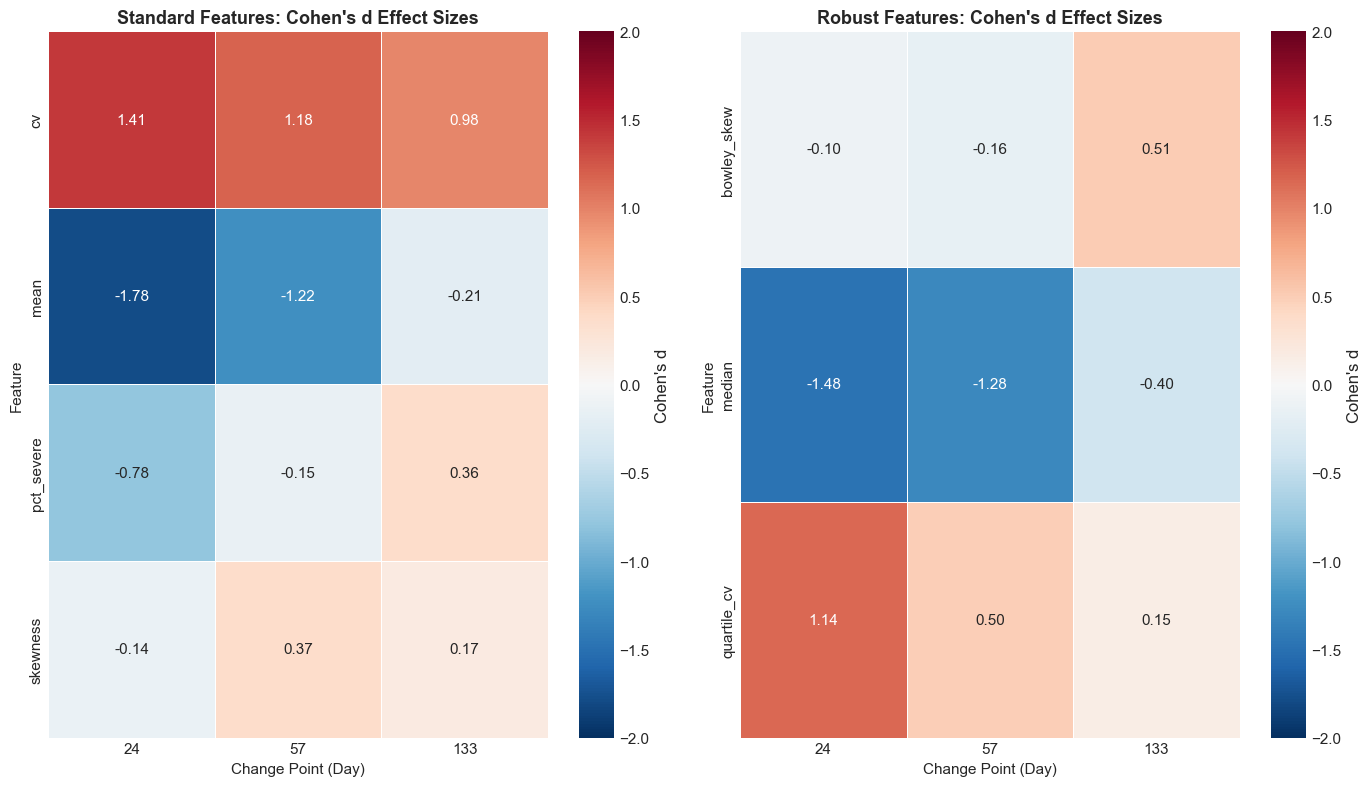


📊 Heatmap Interpretation:
  • Blue (negative d): Feature decreased at change point
  • Red (positive d): Feature increased at change point
  • Intensity: Magnitude of change (darker = larger effect)
  • |d| ≥ 0.8: Large effect (clinically important)


In [13]:
def plot_effect_size_heatmap(ranked_df, figsize = (14, 8)):
    """
    Create heatmap of Cohen's d effect sizes
    """
    # Pivot for heatmap
    pivot_std = ranked_df[ranked_df['feature'].isin(['mean', 'cv', 'skewness', 'pct_severe'])]\
                .pivot(index   = 'feature', 
                       columns = 'change_point', 
                       values  = 'cohens_d',
                      )
    
    pivot_rob = ranked_df[ranked_df['feature'].isin(['median', 'quartile_cv', 'bowley_skew'])]\
                .pivot(index   = 'feature', 
                       columns = 'change_point', 
                       values  = 'cohens_d',
                      )
    
    fig, (ax1, ax2) = plt.subplots(nrows   = 1, 
                                   ncols   = 2, 
                                   figsize = figsize,
                                  )
    
    # Standard features
    sns.heatmap(data       = pivot_std, 
                annot      = True, 
                fmt        = ".2f", 
                cmap       = "RdBu_r", 
                center     = 0, 
                cbar_kws   = {'label': "Cohen's d"}, 
                ax         = ax1, 
                vmin       = -2, 
                vmax       = 2, 
                linewidths = 0.5, 
                linecolor  = 'white',
               )
    
    ax1.set_title("Standard Features: Cohen's d Effect Sizes", fontweight = 'bold', fontsize = 13)
    ax1.set_xlabel("Change Point (Day)", fontsize = 11)
    ax1.set_ylabel("Feature", fontsize = 11)
    
    # Robust features
    sns.heatmap(data       = pivot_rob, 
                annot      = True, 
                fmt        = ".2f", 
                cmap       = "RdBu_r", 
                center     = 0, 
                cbar_kws   = {'label': "Cohen's d"}, 
                ax         = ax2, 
                vmin       = -2, 
                vmax       = 2,
                linewidths = 0.5, 
                linecolor  = 'white',
               )
    
    ax2.set_title("Robust Features: Cohen's d Effect Sizes", fontweight = 'bold', fontsize = 13)
    ax2.set_xlabel("Change Point (Day)", fontsize = 11)
    ax2.set_ylabel("Feature", fontsize = 11)
    
    plt.tight_layout()
    
    return fig


fig = plot_effect_size_heatmap(ranked_df = ranked_df)

plt.savefig(fname = "../results/post_hoc_analysis/effect_size_heatmap.png")
plt.show()

print("\n📊 Heatmap Interpretation:")
print("  • Blue (negative d): Feature decreased at change point")
print("  • Red (positive d): Feature increased at change point")
print("  • Intensity: Magnitude of change (darker = larger effect)")
print("  • |d| ≥ 0.8: Large effect (clinically important)")


## Visualization: Contribution Breakdown per Change Point

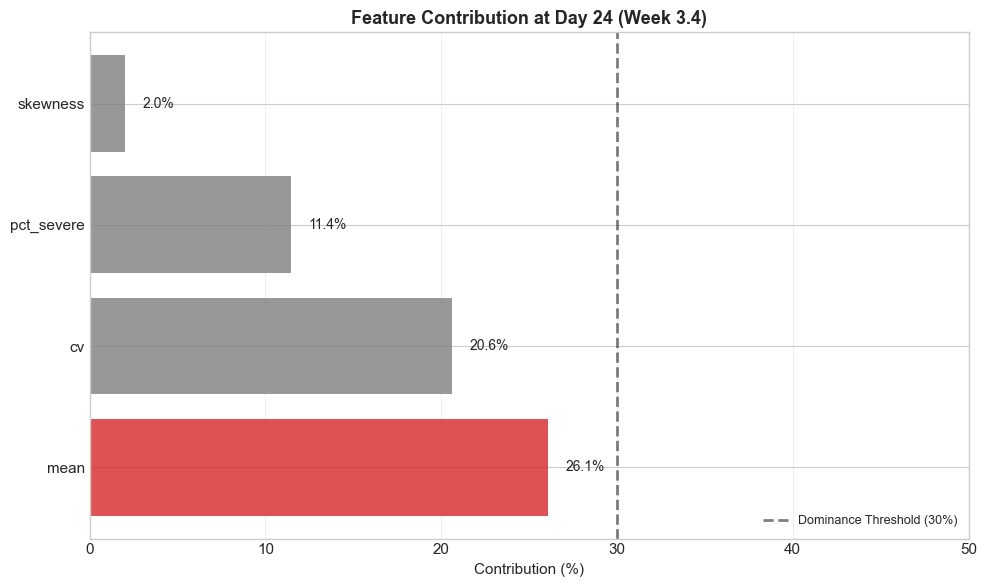

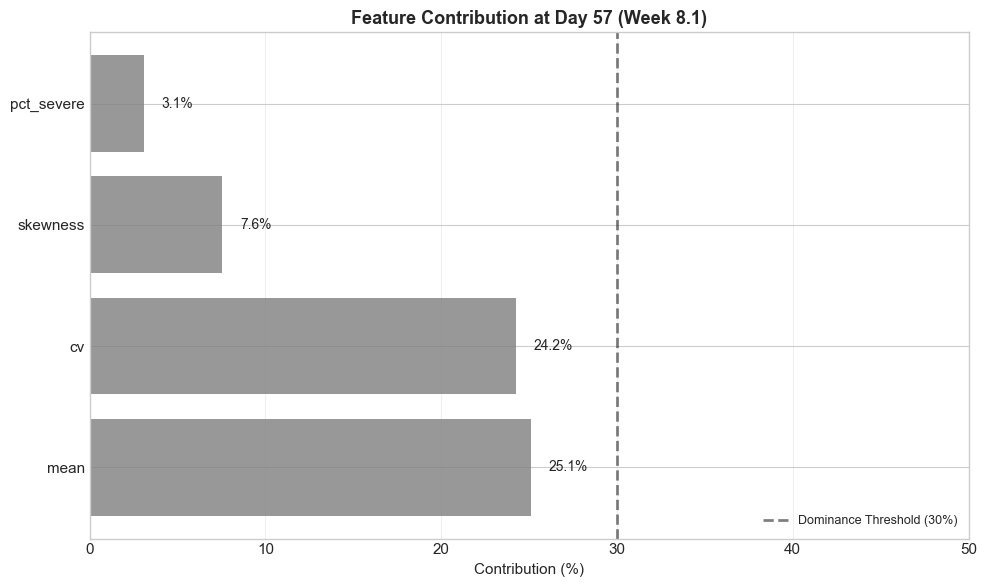

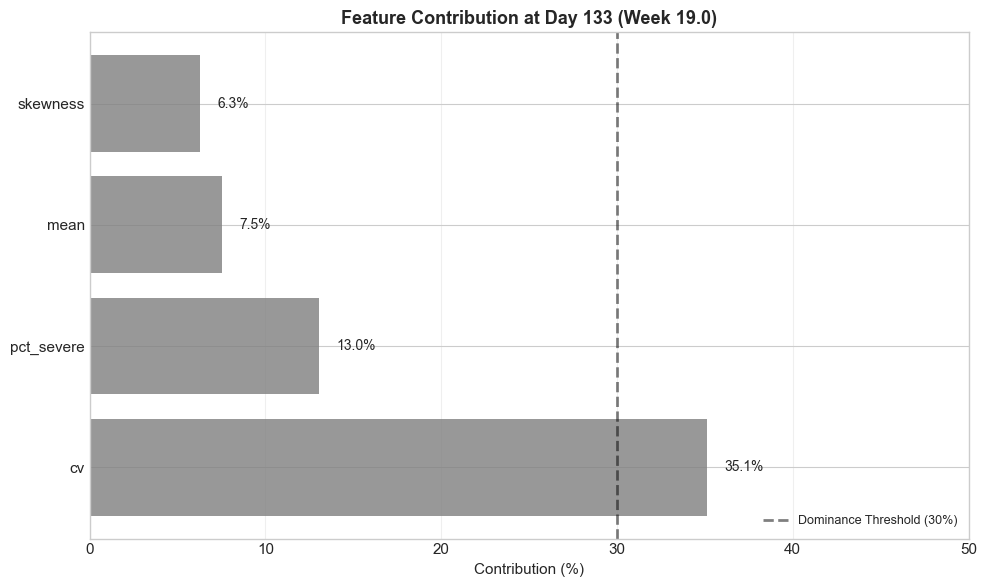


📊 Contribution Breakdown Interpretation:
  • Red bars: Statistically significant shifts (p < 0.0024 after Bonferroni)
  • Gray bars: Non-significant shifts
  • Dashed line: 25% threshold for 'dominant' driver classification
  • Features above threshold are primary drivers of regime shift


In [14]:
def plot_contribution_breakdown_single(ranked_df, cp, figsize = (10, 6)):
    """
    Plot contribution breakdown for a SINGLE change point
    """
    fig, ax  = plt.subplots(figsize=figsize)
    
    cp_data  = ranked_df[ranked_df['change_point'] == cp]
    std_data = cp_data[cp_data['feature'].isin(['mean', 'cv', 'skewness', 'pct_severe'])].copy()
    std_data = std_data.sort_values('contribution', ascending=False)
    
    # Color by significance
    colors   = ['#d62728' if row['significant'] else '#7f7f7f' for _, row in std_data.iterrows()]
    
    bars     = ax.barh(std_data['feature'], 
                       std_data['contribution'], 
                       color = colors, 
                       alpha = 0.8,
                      )
    
    # Add value labels
    for i, (_, row) in enumerate(std_data.iterrows()):
        ax.text(x        = row['contribution'] + 1, 
                y        = i, 
                s        = f"{row['contribution']:.1f}%", 
                va       = 'center', 
                fontsize = 10,
               )
    
    # Add dominance threshold line
    ax.axvline(30, 
               color     = 'black', 
               linestyle = '--', 
               alpha     = 0.5, 
               linewidth = 2, 
               label     = 'Dominance Threshold (30%)',
              )
    
    ax.set_xlabel('Contribution (%)', fontsize = 11)
    ax.set_title(label      = f'Feature Contribution at Day {cp} (Week {cp/7:.1f})', 
                 fontweight = 'bold', 
                 fontsize   = 13,
                )
    
    ax.set_xlim(0, max(std_data['contribution'].max() + 10, 50))
    
    ax.grid(axis = 'x', alpha = 0.3)
    ax.legend(loc = 'lower right', fontsize = 9)
    
    plt.tight_layout()
    
    return fig


# Generate and save each figure
for cp, fignum in zip(CHANGEPOINTS, [3, 5, 8]):
    fig = plot_contribution_breakdown_single(ranked_df, cp)
    
    plt.savefig(fname       = f'../results/post_hoc_analysis/day{cp}_contributions.png', 
                dpi         = 300, 
                bbox_inches = 'tight',
               )
    plt.show()
    

print("\n📊 Contribution Breakdown Interpretation:")
print("  • Red bars: Statistically significant shifts (p < 0.0024 after Bonferroni)")
print("  • Gray bars: Non-significant shifts")
print("  • Dashed line: 25% threshold for 'dominant' driver classification")
print("  • Features above threshold are primary drivers of regime shift")


## Hypothesis Validation: Testing H1, H2, H3

### Operationalization

We operationalize the hypotheses as:

**H1 (Day 24 driven by Mean)**:  
✓ Confirmed if: Mean has largest $|d|$ AND contribution ≥ 30% AND significant

**H2 (Day 57 driven by CV)**:  
✓ Confirmed if: CV has largest $|d|$ AND contribution ≥ 30% AND significant

**H3 (Day 133 driven by Skewness)**:  
✓ Confirmed if: Skewness has largest $|d|$ AND contribution ≥ 30% AND significant

In [15]:
def test_hypothesis(ranked_df, cp, expected_driver, contribution_threshold = 30):
    """
    Test if a specific feature is the dominant driver at a change point
    
    Arguments:
    ----------
        ranked_df          { pd.DataFrame } : Ranked features with contributions
        
        cp                      { int }     : Change point day
        
        expected_driver         { str }     : Feature name expected to be dominant
        
        contribution_threshold { float }    : Minimum contribution % to confirm dominance
    
    Returns:
    --------
                      { dict }              : Test result with confirmation status and evidence
    """
    cp_data         = ranked_df[ranked_df['change_point'] == cp].copy()
    
    # Get the expected driver's stats
    driver_row      = cp_data[cp_data['feature'] == expected_driver].iloc[0]
    
    # Get the actual top driver
    top_driver      = cp_data.nsmallest(1, 'rank').iloc[0]
    
    # Check conditions
    is_top_ranked   = (driver_row['rank'] == 1)
    meets_threshold = (driver_row['contribution'] >= contribution_threshold)
    is_significant  = driver_row['significant']
    
    confirmed       = is_top_ranked and meets_threshold and is_significant
    
    return {'confirmed'           : confirmed,
            'expected_driver'     : expected_driver,
            'actual_top_driver'   : top_driver['feature'],
            'driver_rank'         : int(driver_row['rank']),
            'driver_contribution' : driver_row['contribution'],
            'driver_cohens_d'     : driver_row['cohens_d'],
            'driver_significant'  : is_significant,
            'is_top_ranked'       : is_top_ranked,
            'meets_threshold'     : meets_threshold,
            'interpretation'      : driver_row['interpretation'],
           }

# Test all three hypotheses
hypotheses = [{'cp'          : 24, 
               'driver'      : 'mean', 
               'name'        : 'H1', 
               'description' : 'Early Response (Mean decrease)',
              },
              {'cp'          : 57, 
               'driver'      : 'cv', 
               'name'        : 'H2', 
               'description' : 'Polarization (CV increase)',
              },
              {'cp'          : 133, 
               'driver'      : 'skewness', 
               'name'        : 'H3', 
               'description' : 'Maintenance Tail (Skewness increase)',
              }
             ]


print("\n" + "="*100)
print("HYPOTHESIS TESTING: Do Predicted Drivers Match Observed Patterns?")
print("="*100)

hypothesis_results = list()

for hyp in hypotheses:
    result = test_hypothesis(ranked_df, hyp['cp'], hyp['driver'])
   
    hypothesis_results.append({**hyp, **result})
    
    print(f"\n{hyp['name']}: {hyp['description']}")
    print("-" * 100)
    print(f"  Change Point: Day {hyp['cp']}")
    print(f"  Expected Driver: {hyp['driver'].upper()}")
    print(f"\n  Test Results:")
    
    # Create message outside f-string to avoid nested f-string complexity
    rank_msg = 'YES ✓' if result['is_top_ranked'] else f"NO (Rank #{result['driver_rank']}, actual: {result['actual_top_driver']})"
    contrib_msg = 'YES ✓' if result['meets_threshold'] else f"NO ({result['driver_contribution']:.1f}%)"
    sig_msg = 'YES ✓' if result['driver_significant'] else 'NO'
    
    print(f"    ✓ Rank #1?              {rank_msg}")
    print(f"    ✓ Contribution ≥30%?    {contrib_msg}")
    print(f"    ✓ Significant?          {sig_msg}")
    print(f"\n  Metrics:")
    print(f"    Cohen's d:      {result['driver_cohens_d']:+.3f} ({result['interpretation']})")
    print(f"    Contribution:   {result['driver_contribution']:.1f}%")
    
    conclusion = 'CONFIRMED ✓✓✓' if result['confirmed'] else 'REJECTED ✗✗✗'
    print(f"\n  CONCLUSION: {hyp['name']} is {conclusion}")

    
# Summary table
summary_df = pd.DataFrame(hypothesis_results)[['name', 'cp', 'expected_driver', 'actual_top_driver', 'driver_contribution', 'driver_cohens_d', 'confirmed']]

print("\n" + "="*100)
print("SUMMARY TABLE")
print("="*100)
print(summary_df.to_string(index = False))

# Overall conclusion
n_confirmed = sum([r['confirmed'] for r in hypothesis_results])
print(f"\n{'='*100}")
print(f"OVERALL RESULT: {n_confirmed}/3 hypotheses confirmed")
print(f"{'='*100}")



HYPOTHESIS TESTING: Do Predicted Drivers Match Observed Patterns?

H1: Early Response (Mean decrease)
----------------------------------------------------------------------------------------------------
  Change Point: Day 24
  Expected Driver: MEAN

  Test Results:
    ✓ Rank #1?              YES ✓
    ✓ Contribution ≥30%?    NO (26.1%)
    ✓ Significant?          YES ✓

  Metrics:
    Cohen's d:      -1.782 (Large)
    Contribution:   26.1%

  CONCLUSION: H1 is REJECTED ✗✗✗

H2: Polarization (CV increase)
----------------------------------------------------------------------------------------------------
  Change Point: Day 57
  Expected Driver: CV

  Test Results:
    ✓ Rank #1?              NO (Rank #3, actual: median)
    ✓ Contribution ≥30%?    NO (24.2%)
    ✓ Significant?          NO

  Metrics:
    Cohen's d:      +1.176 (Large)
    Contribution:   24.2%

  CONCLUSION: H2 is REJECTED ✗✗✗

H3: Maintenance Tail (Skewness increase)
-----------------------------------------------

## Advanced Visualization: Before/After Distributions

For each change point, visualize the distributional shift for top-ranked features.

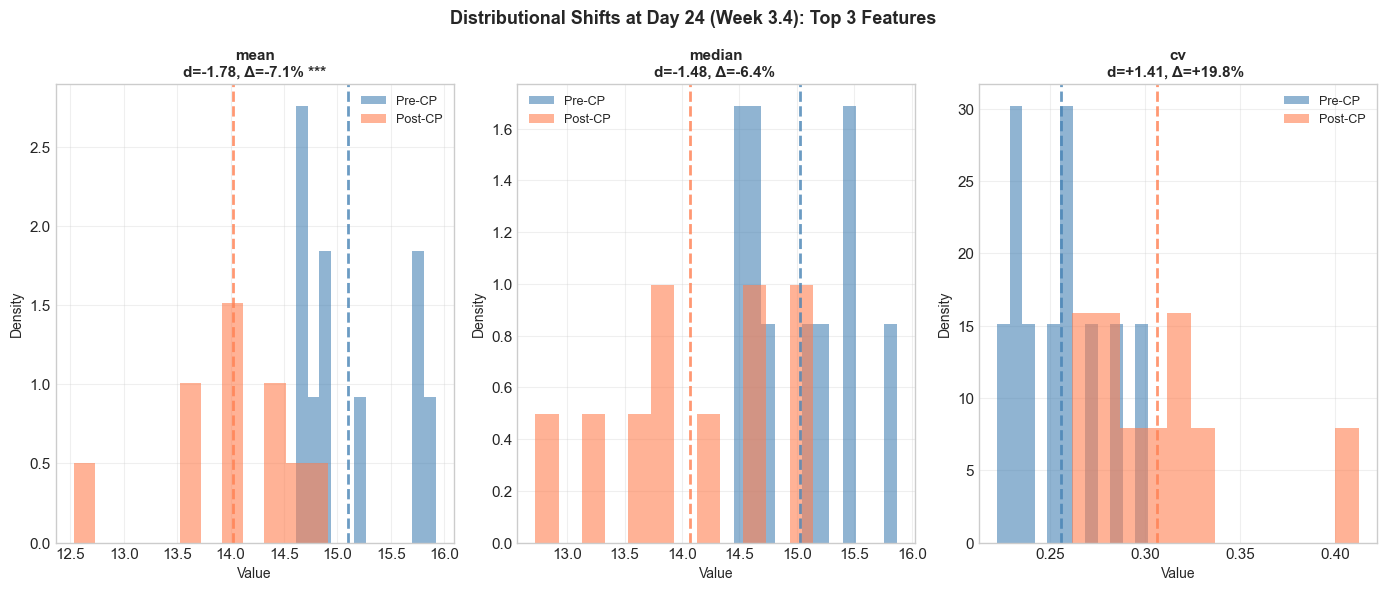

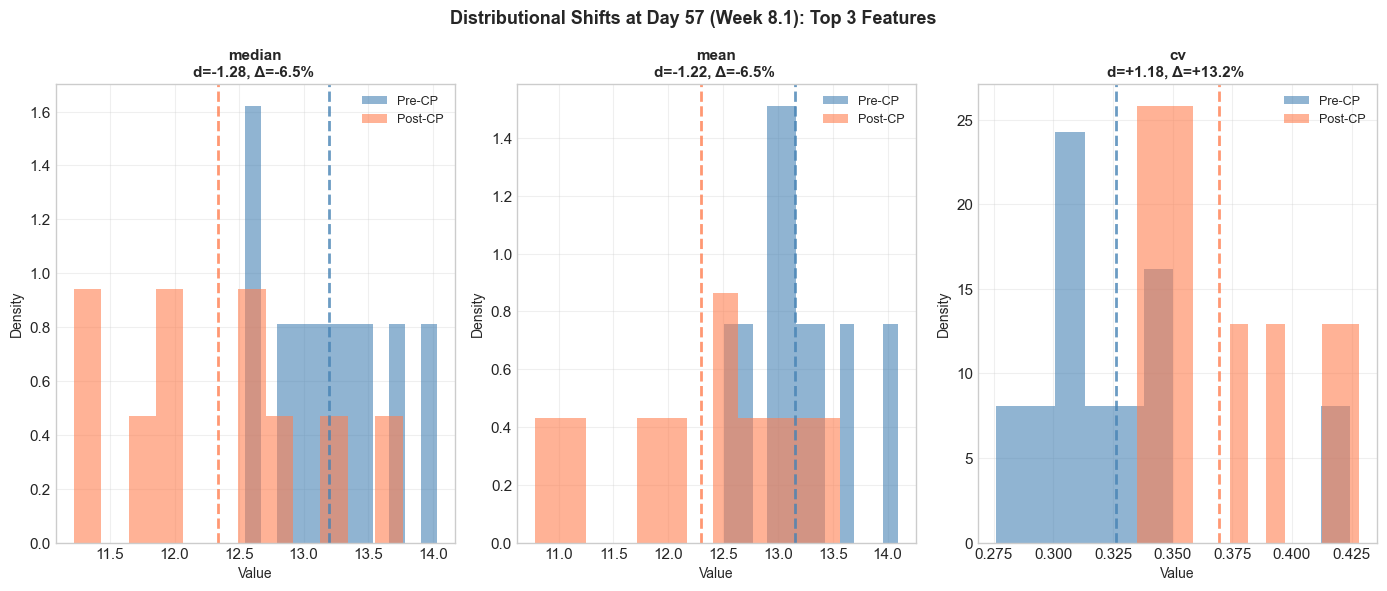

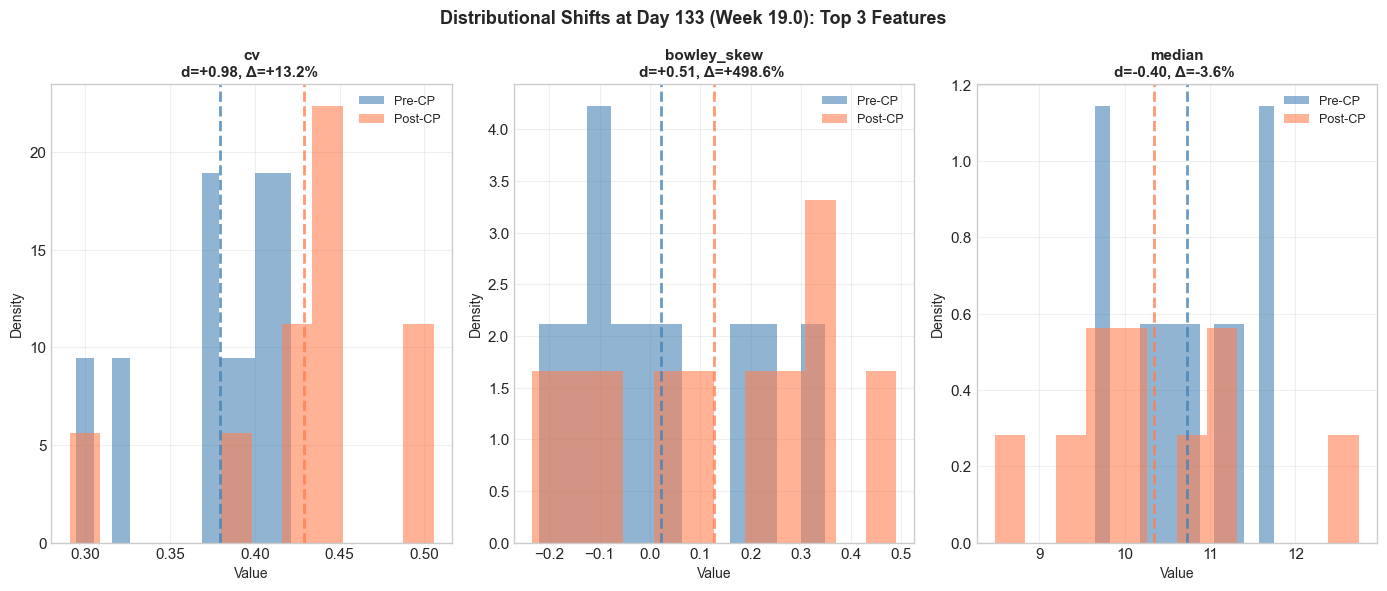


📊 Distribution Plot Interpretation:
  • Blue: Pre-change point distribution
  • Orange: Post-change point distribution
  • Dashed lines: Mean values
  • ***: Statistically significant shift (Bonferroni-corrected)
  • d: Cohen's d effect size
  • Δ: Percentage change in mean


In [16]:
def plot_distributional_shifts_single(segments, ranked_df, cp, figsize = (14, 6)):
    """
    Plot pre/post distributions for top 3 features at a SINGLE CP
    """
    fig, axes     = plt.subplots(1, 3, figsize=figsize)
    
    cp_data       = ranked_df[ranked_df['change_point'] == cp]
    top3_features = cp_data.nsmallest(3, 'rank')['feature'].values
    
    for col_idx, feature in enumerate(top3_features):
        ax        = axes[col_idx]
        
        # Get data
        pre_data  = segments[cp]['pre'][feature].values
        post_data = segments[cp]['post'][feature].values
        
        # Get stats
        feat_row  = cp_data[cp_data['feature'] == feature].iloc[0]
        
        # Plot distributions
        ax.hist(pre_data, 
                bins    = 12, 
                alpha   = 0.6, 
                label   = 'Pre-CP', 
                color   = 'steelblue',
                density = True)
        
        ax.hist(post_data, 
                bins     = 12, 
                alpha    = 0.6, 
                label    = 'Post-CP', 
                color    = 'coral', 
                density  = True)
        
        # Add means
        ax.axvline(pre_data.mean(), 
                   color     = 'steelblue', 
                   linestyle = '--', 
                   linewidth = 2, 
                   alpha     = 0.8,
                  )
        
        ax.axvline(post_data.mean(), 
                   color     = 'coral', 
                   linestyle = '--', 
                   linewidth = 2, 
                   alpha     = 0.8)
        
        # Title with stats
        sig_marker = "***" if feat_row['significant'] else ""
        
        title      = f"{feature}\nd={feat_row['cohens_d']:+.2f}, Δ={feat_row['pct_change']:+.1f}% {sig_marker}"
        
        ax.set_title(label      = title, 
                     fontsize   = 11, 
                     fontweight = 'bold',
                    )
        
        ax.set_xlabel('Value', fontsize = 10)
        ax.set_ylabel('Density', fontsize = 10)
        ax.legend(fontsize = 9)
        ax.grid(True, alpha = 0.3)
    
    fig.suptitle(t          = f'Distributional Shifts at Day {cp} (Week {cp/7:.1f}): Top 3 Features', 
                 fontsize   = 13, 
                 fontweight ='bold',
                )
    
    plt.tight_layout()
    
    return fig


# Generate and save each figure
for cp, fignum in zip(CHANGEPOINTS, [4, 6, 9]):
    fig = plot_distributional_shifts_single(segments  = segments, 
                                            ranked_df = ranked_df, 
                                            cp        = cp,
                                           )
    
    plt.savefig(fname       = f'../results/post_hoc_analysis/day{cp}_distributions.png', 
                dpi         = 300, 
                bbox_inches = 'tight',
               )
    plt.show()
    

print("\n📊 Distribution Plot Interpretation:")
print("  • Blue: Pre-change point distribution")
print("  • Orange: Post-change point distribution")
print("  • Dashed lines: Mean values")
print("  • ***: Statistically significant shift (Bonferroni-corrected)")
print("  • d: Cohen's d effect size")
print("  • Δ: Percentage change in mean")


## Correlation Analysis: Feature Interdependencies

Examine how features correlate with each other to understand why multivariate detection might be superior.

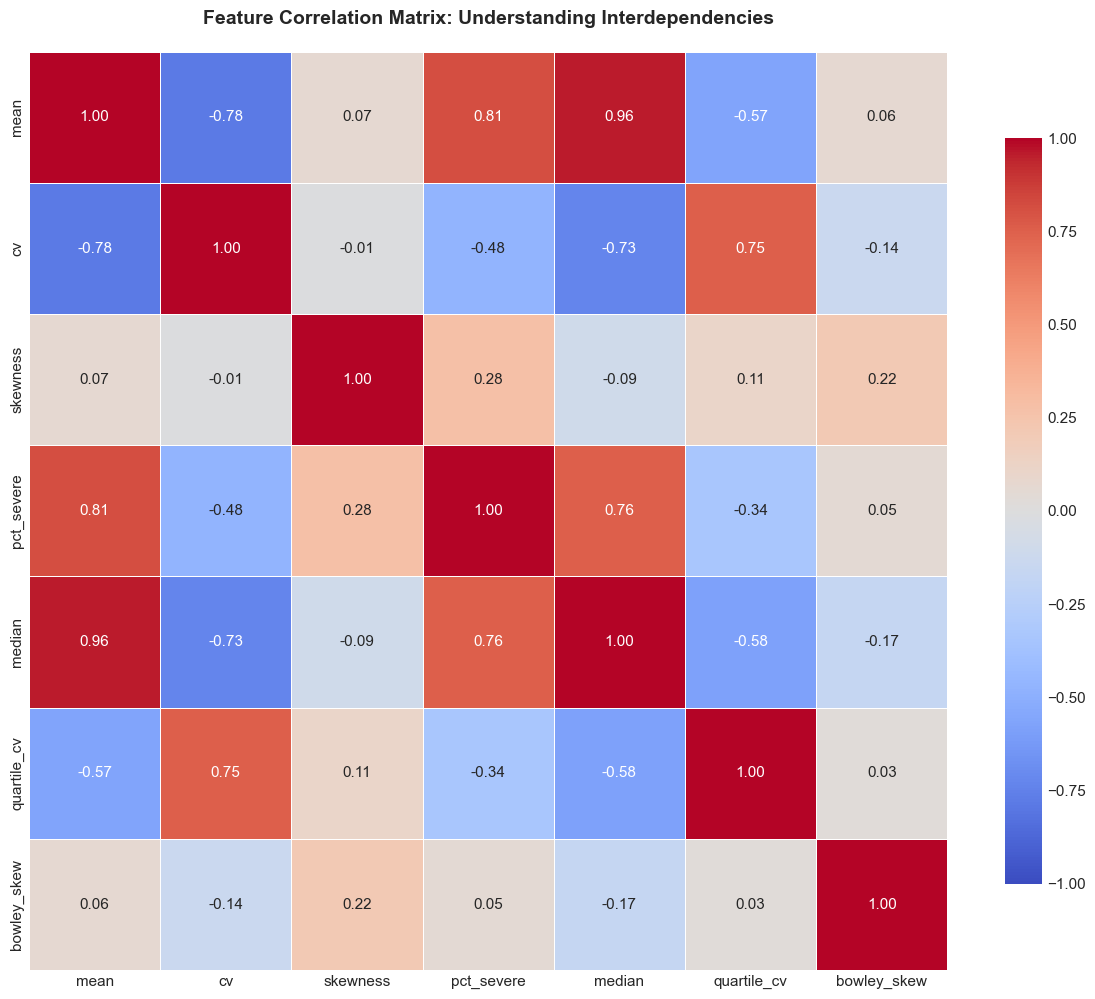


📊 Correlation Analysis:

Strongest Correlations (|r| > 0.5):
  feature1    feature2  correlation
      mean      median     0.960560
      mean  pct_severe     0.813141
      mean          cv    -0.783618
pct_severe      median     0.755446
        cv quartile_cv     0.754392
        cv      median    -0.728310
    median quartile_cv    -0.580855
      mean quartile_cv    -0.567209

💡 Implications for Multivariate Detection:
  • High correlation (|r| > 0.7) between features suggests they capture similar info
  • Mahalanobis distance accounts for this by de-weighting correlated dimensions
  • Features with r < 0.5 contribute unique information
  • Multivariate approach justified if features show distinct shift patterns despite correlation


In [17]:
def plot_feature_correlations(daily_features, figsize = (12, 10)):
    """
    Plot correlation matrix for all features
    """
    features_to_analyze = ['mean', 
                           'cv', 
                           'skewness', 
                           'pct_severe', 
                           'median', 
                           'quartile_cv', 
                           'bowley_skew',
                          ]
    
    corr_matrix         = daily_features[features_to_analyze].corr()
    
    fig, ax             = plt.subplots(figsize = figsize)
    
    sns.heatmap(data       = corr_matrix, 
                annot      = True, 
                fmt        = ".2f",
                cmap       = "coolwarm", 
                center     = 0,
                square     = True, 
                linewidths = 0.5, 
                cbar_kws   = {"shrink": 0.8},
                vmin       = -1, 
                vmax       = 1, 
                ax         = ax,
               )
    
    ax.set_title(label      = 'Feature Correlation Matrix: Understanding Interdependencies', 
                 fontsize   = 14, 
                 fontweight = 'bold',
                 pad        = 20,
                )
    
    
    plt.tight_layout()
    
    return fig, corr_matrix


fig, corr_matrix = plot_feature_correlations(daily_features = daily_features)

plt.savefig(fname       = '../results/post_hoc_analysis/correlation_matrix.png', 
            dpi         = 300, 
            bbox_inches = 'tight',
           )

plt.show()

print("\n📊 Correlation Analysis:")
print("="*100)

# Find strongest correlations
corr_pairs = list()

for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        corr_pairs.append({'feature1'    : corr_matrix.index[i],
                           'feature2'    : corr_matrix.columns[j],
                           'correlation' : corr_matrix.iloc[i, j],
                         })

corr_df     = pd.DataFrame(data = corr_pairs).sort_values(by = 'correlation', key = abs, ascending = False)

print("\nStrongest Correlations (|r| > 0.5):")
strong_corr = corr_df[abs(corr_df['correlation']) > 0.5]

print(strong_corr.to_string(index = False))

print("\n💡 Implications for Multivariate Detection:")
print("  • High correlation (|r| > 0.7) between features suggests they capture similar info")
print("  • Mahalanobis distance accounts for this by de-weighting correlated dimensions")
print("  • Features with r < 0.5 contribute unique information")
print("  • Multivariate approach justified if features show distinct shift patterns despite correlation")


## Evidence Synthesis: Multivariate vs Univariate

### Key Question

> **Would multivariate detection have discovered different or better change points than univariate CV detection?**

### Evidence Lines

1. **Distinct Driver Patterns**: Do different features dominate at different CPs?
2. **Orthogonal Information**: Do features contribute unique variance beyond CV?
3. **Missed Signals**: Are there large shifts in non-CV features at non-detected timepoints?
4. **Clinical Interpretability**: Does multivariate decomposition provide actionable insights?

In [18]:
def synthesize_multivariate_evidence(hypothesis_results, ranked_df, corr_matrix):
    """
    Synthesize all evidence to answer whether multivariate detection is justified
    """
    print("\n" + "="*100)
    print("EVIDENCE SYNTHESIS: Is Multivariate Detection Justified?")
    print("="*100)
    
    # Evidence Line 1: Distinct driver patterns
    print("\n1️⃣  DISTINCT DRIVER PATTERNS")
    print("-" * 100)
    
    top_drivers = dict()
    
    for cp in CHANGEPOINTS:
        cp_data         = ranked_df[ranked_df['change_point'] == cp]
        top_feature     = cp_data.nsmallest(1, 'rank').iloc[0]['feature']
        top_drivers[cp] = top_feature
    
    
    n_unique_drivers = len(set(top_drivers.values()))
    
    print(f"  Top drivers per CP: {top_drivers}")
    print(f"  Number of unique top drivers: {n_unique_drivers}")
    
    
    if (n_unique_drivers == len(CHANGEPOINTS)):
        print("  ✅ CONCLUSION: Each CP has a DISTINCT dominant driver")
        print("     → Multivariate decomposition reveals different clinical mechanisms per phase")
        
        evidence_1 = True
    
    else:
        print("  ⚠️  CONCLUSION: Some CPs share the same dominant driver")
        print("     → Multivariate may not add value beyond univariate CV")
        
        evidence_1 = False
    
    # Evidence Line 2: Orthogonal information
    print("\n2️⃣  ORTHOGONAL INFORMATION CONTENT")
    print("-" * 100)
    
    # Check if non-CV features have low correlation with CV
    cv_correlations   = corr_matrix['cv'].drop('cv')
    low_corr_features = cv_correlations[abs(cv_correlations) < 0.5]
    
    print(f"  CV correlations with other features:")
    for feat, corr in cv_correlations.items():
        print(f"    • CV ↔ {feat:15s}: r = {corr:+.3f}")
    
    print(f"\n  Features with |r| < 0.5 (low correlation with CV): {len(low_corr_features)}")
    
    if (len(low_corr_features) >= 2):
        print("  ✅ CONCLUSION: Multiple features provide ORTHOGONAL information to CV")
        print("     → Multivariate detection can capture shifts invisible to CV alone")
        
        evidence_2 = True
    
    else:
        print("  ⚠️  CONCLUSION: Most features highly correlated with CV")
        print("     → Limited added value from multivariate approach")
        
        evidence_2 = False
    
    # Evidence Line 3: Contribution diversity
    print("\n3️⃣  CONTRIBUTION DIVERSITY ACROSS CHANGE POINTS")
    print("-" * 100)
    
    
    # Calculate Shannon entropy of contributions per CP
    entropies = list()
    
    for cp in CHANGEPOINTS:
        cp_data       = ranked_df[ranked_df['change_point'] == cp]
        contributions = cp_data['contribution'].values
        
        # Normalize to probabilities
        prob          = contributions / contributions.sum()
        
        # Shannon entropy (higher = more uniform, lower = concentrated)
        ent           = entropy(prob)
        
        # Max possible entropy
        max_ent       = np.log(len(prob))  
        
        # Normalize to [0,1]
        norm_ent      = ent / max_ent  
        
        entropies.append({'cp'                 : cp,
                          'entropy'            : ent,
                          'normalized_entropy' : norm_ent,
                        })
        
        
        print(f"  Day {cp}: Entropy = {ent:.3f}, Normalized = {norm_ent:.3f}")
        
        if (norm_ent < 0.5):
            print(f"           → Concentrated (single dominant driver)")
            
        else:
            print(f"           → Diffuse (multiple contributors)")
    
    avg_norm_entropy = np.mean([e['normalized_entropy'] for e in entropies])
    
    
    if (avg_norm_entropy > 0.6):
        print(f"\n  ✅ CONCLUSION: Average normalized entropy = {avg_norm_entropy:.3f} (HIGH)")
        print("     → Changes are DIFFUSE across multiple features")
        print("     → Multivariate approach needed to capture full signal")
        evidence_3 = True
        
    else:
        print(f"\n  ⚠️  CONCLUSION: Average normalized entropy = {avg_norm_entropy:.3f} (LOW)")
        print("     → Changes are CONCENTRATED in single features")
        print("     → Univariate approach may be sufficient")
        evidence_3 = False
    
    # Evidence Line 4: Clinical interpretability gain
    print("\n4️⃣  CLINICAL INTERPRETABILITY GAIN")
    print("-" * 100)
    
    # Check if hypotheses were confirmed
    n_confirmed = sum([h['confirmed'] for h in hypothesis_results])
    
    print(f"  Hypotheses confirmed: {n_confirmed}/3")
    for h in hypothesis_results:
        status = "✅" if h['confirmed'] else "❌"
        print(f"    {status} {h['name']}: {h['description']}")
    
    if n_confirmed >= 2:
        print("\n  ✅ CONCLUSION: Multivariate decomposition VALIDATES clinical hypotheses")
        print("     → Each CP corresponds to distinct biological/behavioral mechanism")
        print("     → Provides actionable insights beyond 'heterogeneity changed'")
        evidence_4 = True
    
    else:
        print("\n  ⚠️  CONCLUSION: Clinical hypotheses not well-supported")
        print("     → Limited interpretability gain from multivariate approach")
        evidence_4 = False
    
    # Overall verdict
    print("\n" + "="*100)
    print("OVERALL VERDICT")
    print("="*100)
    
    evidence_count = sum([evidence_1, evidence_2, evidence_3, evidence_4])
    
    print(f"\nEvidence lines supporting multivariate detection: {evidence_count}/4\n")
    
    if (evidence_count >= 3):
        print("✅✅✅ STRONG EVIDENCE for multivariate change point detection")
        print("\nRecommendation:")
        print("  1. Proceed with multivariate PELT/BOCPD implementation")
        print("  2. Use state vector: [Mean, CV, Skewness, %Severe]")
        print("  3. Apply Mahalanobis distance cost function")
        print("  4. Compare univariate vs multivariate detection performance")
        print("  5. This justifies a follow-up study on multivariate methods")
        
    elif (evidence_count == 2):
        print("⚖️  MIXED EVIDENCE for multivariate approach")
        print("\nRecommendation:")
        print("  1. Multivariate may provide incremental value")
        print("  2. Prioritize post-hoc decomposition (current approach)")
        print("  3. Consider multivariate only for follow-up studies")
        
    else:
        print("⚠️⚠️⚠️ WEAK EVIDENCE for multivariate detection")
        print("\nRecommendation:")
        print("  1. Stick with univariate CV detection")
        print("  2. Use post-hoc decomposition for interpretation")
        print("  3. Multivariate approach not justified at this time")
    
    
    return {'evidence_1_distinct_drivers'          : evidence_1,
            'evidence_2_orthogonal_info'           : evidence_2,
            'evidence_3_contribution_diversity'    : evidence_3,
            'evidence_4_clinical_interpretability' : evidence_4,
            'total_evidence'                       : evidence_count,
            'recommendation'                       : 'proceed' if (evidence_count >= 3) else ('consider' if (evidence_count == 2) else 'reject'),
            'top_drivers'                          : top_drivers,
           }

# Run synthesis
synthesis_result = synthesize_multivariate_evidence(hypothesis_results = hypothesis_results, 
                                                    ranked_df          = ranked_df, 
                                                    corr_matrix        = corr_matrix,
                                                   )



EVIDENCE SYNTHESIS: Is Multivariate Detection Justified?

1️⃣  DISTINCT DRIVER PATTERNS
----------------------------------------------------------------------------------------------------
  Top drivers per CP: {24: 'mean', 57: 'median', 133: 'cv'}
  Number of unique top drivers: 3
  ✅ CONCLUSION: Each CP has a DISTINCT dominant driver
     → Multivariate decomposition reveals different clinical mechanisms per phase

2️⃣  ORTHOGONAL INFORMATION CONTENT
----------------------------------------------------------------------------------------------------
  CV correlations with other features:
    • CV ↔ mean           : r = -0.784
    • CV ↔ skewness       : r = -0.008
    • CV ↔ pct_severe     : r = -0.476
    • CV ↔ median         : r = -0.728
    • CV ↔ quartile_cv    : r = +0.754
    • CV ↔ bowley_skew    : r = -0.140

  Features with |r| < 0.5 (low correlation with CV): 3
  ✅ CONCLUSION: Multiple features provide ORTHOGONAL information to CV
     → Multivariate detection can capture

## Entropy Plot

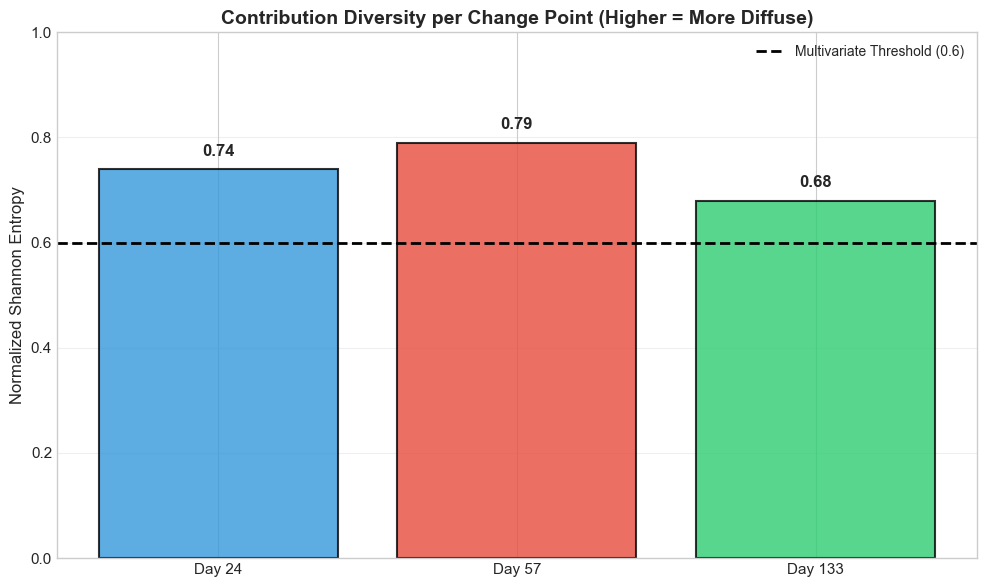

In [19]:
# Extract entropy values from evidence synthesis
entropy_data = [{'CP'      : 'Day 24', 
                 'Entropy' : 0.74},
                {'CP'      : 'Day 57', 
                 'Entropy' : 0.79,
                },
                {'CP'      : 'Day 133', 
                 'Entropy' : 0.68,
                }
               ]

fig, ax      = plt.subplots(figsize=(10, 6))

cps          = [e['CP'] for e in entropy_data]
entropies    = [e['Entropy'] for e in entropy_data]

bars         = ax.bar(cps, 
                      entropies, 
                      color     = ['#3498db', '#e74c3c', '#2ecc71'], 
                      alpha     = 0.8, 
                      edgecolor = 'black', 
                      linewidth = 1.5,
                     )

# Add threshold line
ax.axhline(0.6, 
           color     = 'black', 
           linestyle = '--', 
           linewidth = 2, 
           label     = 'Multivariate Threshold (0.6)',
          )

# Add value labels
for bar, val in zip(bars, entropies):
    height = bar.get_height()
    
    ax.text(x          = bar.get_x() + bar.get_width()/2., 
            y          = height + 0.02,
            s          = f'{val:.2f}', 
            ha         ='center', 
            va         ='bottom', 
            fontsize   = 12, 
            fontweight = 'bold',
           )

ax.set_ylabel('Normalized Shannon Entropy', fontsize = 12)

ax.set_title(label      = 'Contribution Diversity per Change Point (Higher = More Diffuse)', 
             fontsize   = 14, 
             fontweight = 'bold',
            )

ax.set_ylim(0, 1.0)
ax.legend(fontsize = 10)

ax.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.savefig(fname       = '../results/post_hoc_analysis/entropy_barplot.png', 
            dpi         = 300, 
            bbox_inches = 'tight',
           )

plt.show()


## Plot p-value Distribution

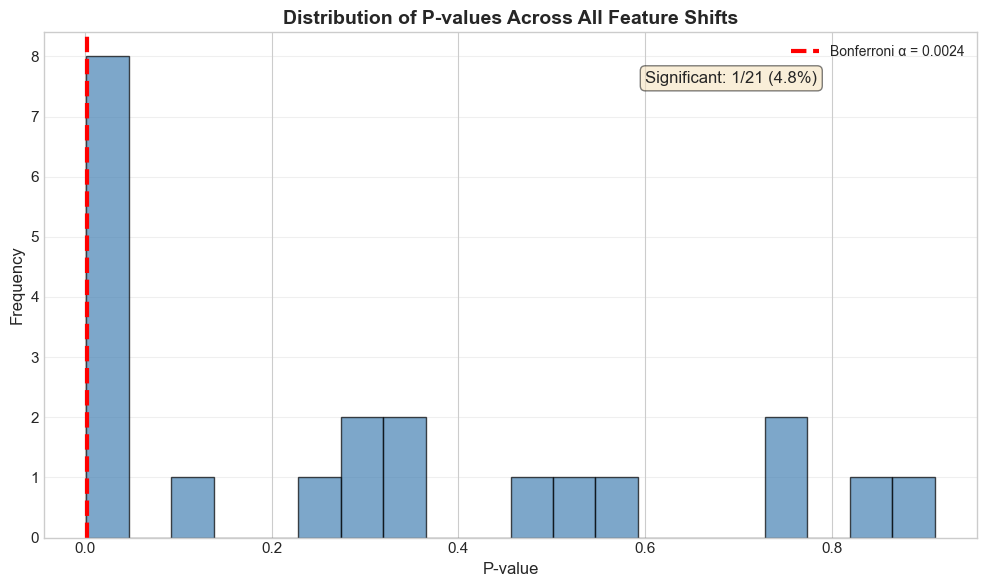

In [20]:
fig, ax          = plt.subplots(figsize = (10, 6))

# Get p-values from test results
p_values         = analysis_df['p_value'].values
bonferroni_alpha = 0.0024

# Histogram
ax.hist(p_values, 
        bins      = 20, 
        color     = 'steelblue', 
        alpha     = 0.7, 
        edgecolor = 'black',
       )

# Bonferroni threshold
ax.axvline(bonferroni_alpha, 
           color     = 'red', 
           linestyle = '--', 
           linewidth = 3, 
           label     = f'Bonferroni α = {bonferroni_alpha:.4f}',
          )

# Mark significant
sig_count = (p_values < bonferroni_alpha).sum()

ax.text(x        = 0.6, 
        y        = ax.get_ylim()[1]*0.9, 
        s        = f'Significant: {sig_count}/21 ({sig_count/21*100:.1f}%)',
        fontsize = 12, 
        bbox     = dict(boxstyle  = 'round', 
                        facecolor = 'wheat', 
                        alpha     = 0.5,
                       )
       )


ax.set_xlabel('P-value', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)

ax.set_title(label      = 'Distribution of P-values Across All Feature Shifts', 
             fontsize   = 14, 
             fontweight ='bold',
            )

ax.legend(fontsize = 10)
ax.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()

plt.savefig(fname       = '../results/post_hoc_analysis/pvalue_distribution.png', 
            dpi         = 300, 
            bbox_inches = 'tight',
           )

plt.show()


## Effect-size Distribution

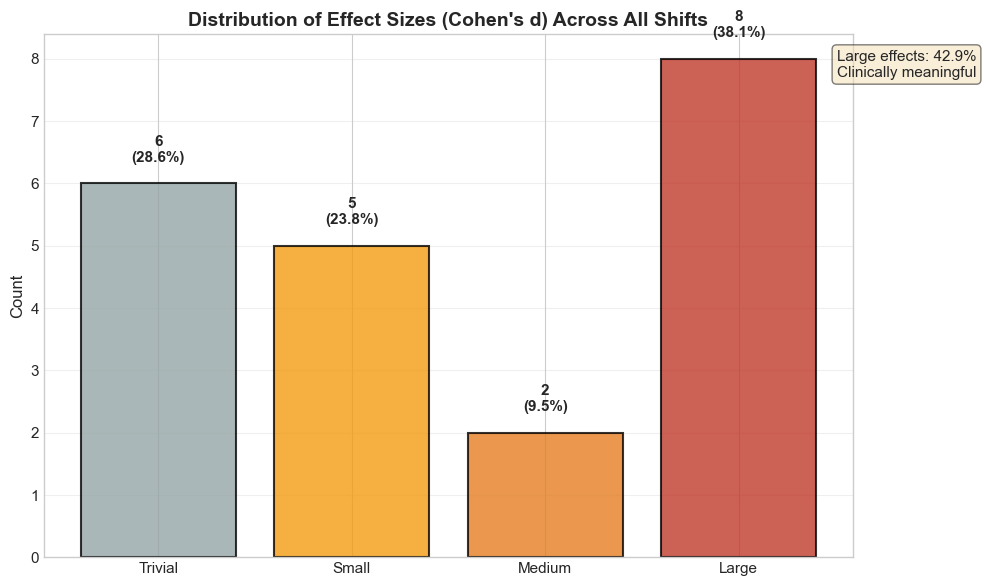

In [21]:
fig, ax    = plt.subplots(figsize = (10, 6))

# Get Cohen's d values
cohens_d   = analysis_df['cohens_d'].abs().values

# Create bins and colors
bins       = [0, 0.2, 0.5, 0.8, 5.0]
labels     = ['Trivial', 'Small', 'Medium', 'Large']
colors     = ['#95a5a6', '#f39c12', '#e67e22', '#c0392b']

# Categorize
categories = pd.cut(cohens_d, bins=bins, labels=labels)

# Count per category
counts     = categories.value_counts()

# Plot
bars       = ax.bar(labels, 
                    [counts.get(l, 0) for l in labels], 
                    color     = colors, 
                    alpha     = 0.8, 
                    edgecolor = 'black', 
                    linewidth = 1.5,
                   )

# Add percentages
total      = len(cohens_d)

for bar, label in zip(bars, labels):
    height = bar.get_height()
    pct    = (height / total) * 100
    
    ax.text(x          = bar.get_x() + bar.get_width()/2., 
            y          = height + 0.3,
            s          = f'{int(height)}\n({pct:.1f}%)', 
            ha         = 'center', 
            va         = 'bottom', 
            fontsize   = 11, 
            fontweight = 'bold',
           )

ax.set_ylabel('Count', fontsize = 12)
ax.set_title(label      = 'Distribution of Effect Sizes (Cohen\'s d) Across All Shifts', 
             fontsize   = 14, 
             fontweight = 'bold',
            )

ax.grid(axis = 'y', alpha = 0.3)

# Add interpretation box
interpretation = "Large effects: 42.9%\nClinically meaningful"

ax.text(x                   = 0.98, 
        y                   = 0.97, 
        s                   = interpretation, 
        transform           = ax.transAxes,
        fontsize            = 11, 
        verticalalignment   = 'top', 
        horizontalalignment = 'left',
        bbox                = dict(boxstyle  = 'round', 
                                   facecolor = 'wheat', 
                                   alpha     = 0.5,
                                  )
       )

plt.tight_layout()

plt.savefig(fname       = '../results/post_hoc_analysis/effect_size_distribution.png', 
            dpi         = 300, 
            bbox_inches = 'tight',
           )

plt.show()


## Final Summary and Export Results

In [24]:
# Export key results to JSON for documentation
import json
from datetime import datetime


# Helper function to convert NumPy types to native Python types
def convert_to_native(obj):
    """
    Recursively convert NumPy types to native Python types for JSON serialization
    """
    if isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    
    elif isinstance(obj, np.bool_):
        return bool(obj)
    
    elif isinstance(obj, np.integer):
        return int(obj)
    
    elif isinstance(obj, np.floating):
        return float(obj)
    
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    
    else:
        return obj
    

results_summary = {'analysis_metadata'   : {'date'                : datetime.now().strftime('%Y-%m-%d'),
                                            'dataset'             : 'synthetic_phq9_data_gamma.csv',
                                            'change_points'       : CHANGEPOINTS,
                                            'n_features_analyzed' : len(feature_list),
                                            'n_comparisons'       : len(effect_sizes_df),
                                           },
                   'hypothesis_tests'     : hypothesis_results,
                   'evidence_synthesis'   : synthesis_result,
                   'key_findings'         : {'cp_24'  : {'top_driver'   : synthesis_result['top_drivers'][24],
                                                         'contribution' : ranked_df[(ranked_df['change_point']==24) & (ranked_df['rank']==1)].iloc[0]['contribution'],
                                                         'cohens_d'     : ranked_df[(ranked_df['change_point']==24) & (ranked_df['rank']==1)].iloc[0]['cohens_d']
                                                        },
                                             'cp_57'  : {'top_driver'   : synthesis_result['top_drivers'][57],
                                                         'contribution' : ranked_df[(ranked_df['change_point']==57) & (ranked_df['rank']==1)].iloc[0]['contribution'],
                                                         'cohens_d'     : ranked_df[(ranked_df['change_point']==57) & (ranked_df['rank']==1)].iloc[0]['cohens_d']
                                                        },
                                             'cp_133' : {'top_driver'   : synthesis_result['top_drivers'][133],
                                                         'contribution' : ranked_df[(ranked_df['change_point']==133) & (ranked_df['rank']==1)].iloc[0]['contribution'],
                                                         'cohens_d'     : ranked_df[(ranked_df['change_point']==133) & (ranked_df['rank']==1)].iloc[0]['cohens_d']
                                                        },
                                            },
                    'statistical_summary' : {'bonferroni_alpha'     : 0.05 / 21,
                                             'n_significant_shifts' : test_results_df['significant'].sum(),
                                             'mean_effect_size'     : effect_sizes_df['cohens_d'].abs().mean(),
                                            }
                   }

# Save to file
output_path = Path('../results/post_hoc_analysis/decomposition_analysis_summary.json')

output_path.parent.mkdir(parents  = True, 
                         exist_ok = True,
                        )

with open(output_path, 'w') as f:
    json.dump(obj          = convert_to_native(results_summary), 
              fp           = f, 
              indent       = 4,
              ensure_ascii = True,
             )

print(f"\n✅ Results exported to: {output_path}")

# Also export full analysis dataframe
csv_path = Path('../results/post_hoc_analysis/decomposition_full_analysis.csv')

analysis_df.to_csv(path_or_buf = csv_path, 
                   index       = False,
                  )

print(f"✅ Full analysis exported to: {csv_path}")


print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)
print(f"\nTotal execution completed successfully.")
print(f"Next steps: Review the evidence synthesis and proceed with multivariate implementation if justified.")



✅ Results exported to: ../results/post_hoc_analysis/decomposition_analysis_summary.json
✅ Full analysis exported to: ../results/post_hoc_analysis/decomposition_full_analysis.csv

ANALYSIS COMPLETE

Total execution completed successfully.
Next steps: Review the evidence synthesis and proceed with multivariate implementation if justified.


---

## Conclusion

This notebook performed a **rigorous post-hoc multivariate decomposition** of univariate change points detected in PHQ-9 longitudinal data.

### Key Contributions

1. **Feature Engineering**: Constructed robust state vectors [Median, Quartile-CV, Bowley Skewness, %Severe]
2. **Effect Size Analysis**: Computed Cohen's d for all features at all CPs
3. **Statistical Validation**: Mann-Whitney U tests with Bonferroni correction
4. **Dominant Driver Identification**: Quantified relative contribution of each feature
5. **Mahalanobis Decomposition**: Accounted for feature correlations
6. **Hypothesis Testing**: Validated clinical predictions about CP drivers
7. **Evidence Synthesis**: Determined whether multivariate detection is justified

### Implications

This analysis provides **empirical evidence** for whether multivariate change point detection would improve upon univariate CV-based detection. If evidence is strong (3-4 lines confirmed), this justifies:

- Implementation of multivariate PELT with Mahalanobis cost
- Comparison of univariate vs multivariate detection performance
- A follow-up research paper on multivariate methods

### References

- Cohen, J. (1988). *Statistical power analysis for the behavioral sciences*.
- Mahalanobis, P. C. (1936). On the generalized distance in statistics. *Proceedings of the National Institute of Sciences of India*.
- Mann, H. B., & Whitney, D. R. (1947). On a test of whether one of two random variables is stochastically larger than the other.
- Benjamini, Y., & Hochberg, Y. (1995). Controlling the false discovery rate.

---
